In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy.io import readsav
from scipy.stats import norm as normDist
from scipy.optimize import curve_fit
from scipy import optimize

import pandas as pd

import re

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

import matplotlib.mlab as mlab
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter

pylab.rcParams['figure.figsize'] = (10,8)
# pylab.rcParams['font.size'] = 22
pylab.rcParams.update({'font.size': 22, 'text.usetex': True})
# matplotlib.rcParams.update({'font.size': 22, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import igm as lyA
import buildFluxTables as bft
import loadSP as lsp

import linecache
import os
import subprocess
import glob
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [3]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
cosmo = FlatLambdaCDM(H0=73.2, Om0=0.24, Ob0=0.0449,name='myCosmo')

In [4]:
#
# Convert flux into magnitude, no extinction...
#
ABref = 48.6
def mag(flux):
    return -2.5 * np.log10(flux) - ABref

# Load data... 

In [5]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# REMEMBER, SB99 data is for a population of 1e6 M_sun
# THIS IS WHY I HAVE "-6" when constructing the flux per wavelen below... 
rootPath = '/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/27Aug15-3Mpc-output/' # Home computer dir... 
rootPath = '/Users/earnric/OneDrive/27Aug15-3Mpc-output/' # Home computer dir... 
filePat = 'haloFluxes_UV_z_*_r75.txt' ###### We are using DM determined halos here... note the .75 R_v -> r75 ########
files   = glob.glob(rootPath+filePat)  # All the files in the dir... should be one!
fileListz = []
for file in files:
    start = file.index('z_') + 2
    end = file.index('.txt') - 4
    fileListz.append(file[start:end])
fluxes = {float(filez):  np.genfromtxt(file, delimiter=',',names=True) for filez,file in zip(fileListz,files)}
# Access fluxes as: fluxes[z][filter] to get a list of fluxes for the halos... 
# Also possible are indx, <Z>/Z_sun, <Z_P>/Z_sun, M/M_sun

In [6]:
for z in fileListz:
    print(z,len(fluxes[float(z)]['indx'])) 
thezs= [float(i) for i in fileListz]


10.0 122
11.0 94
12.0 62
13.0 40
14.0 23
15.0 15
16.0 8
5.0 280
5.5 310
6.0 333
6.5 374
7.0 386
7.5 389
8.0 356
8.5 273
9.0 195
9.5 136


In [7]:
print(fluxes[6].dtype.names)

('indx', 'ZZ_sun', 'Z_PZ_sun', 'MM_sun', '1500A_restFlux', '1500A_restFlux_P3', '1500A_restFlux_NM')


20364

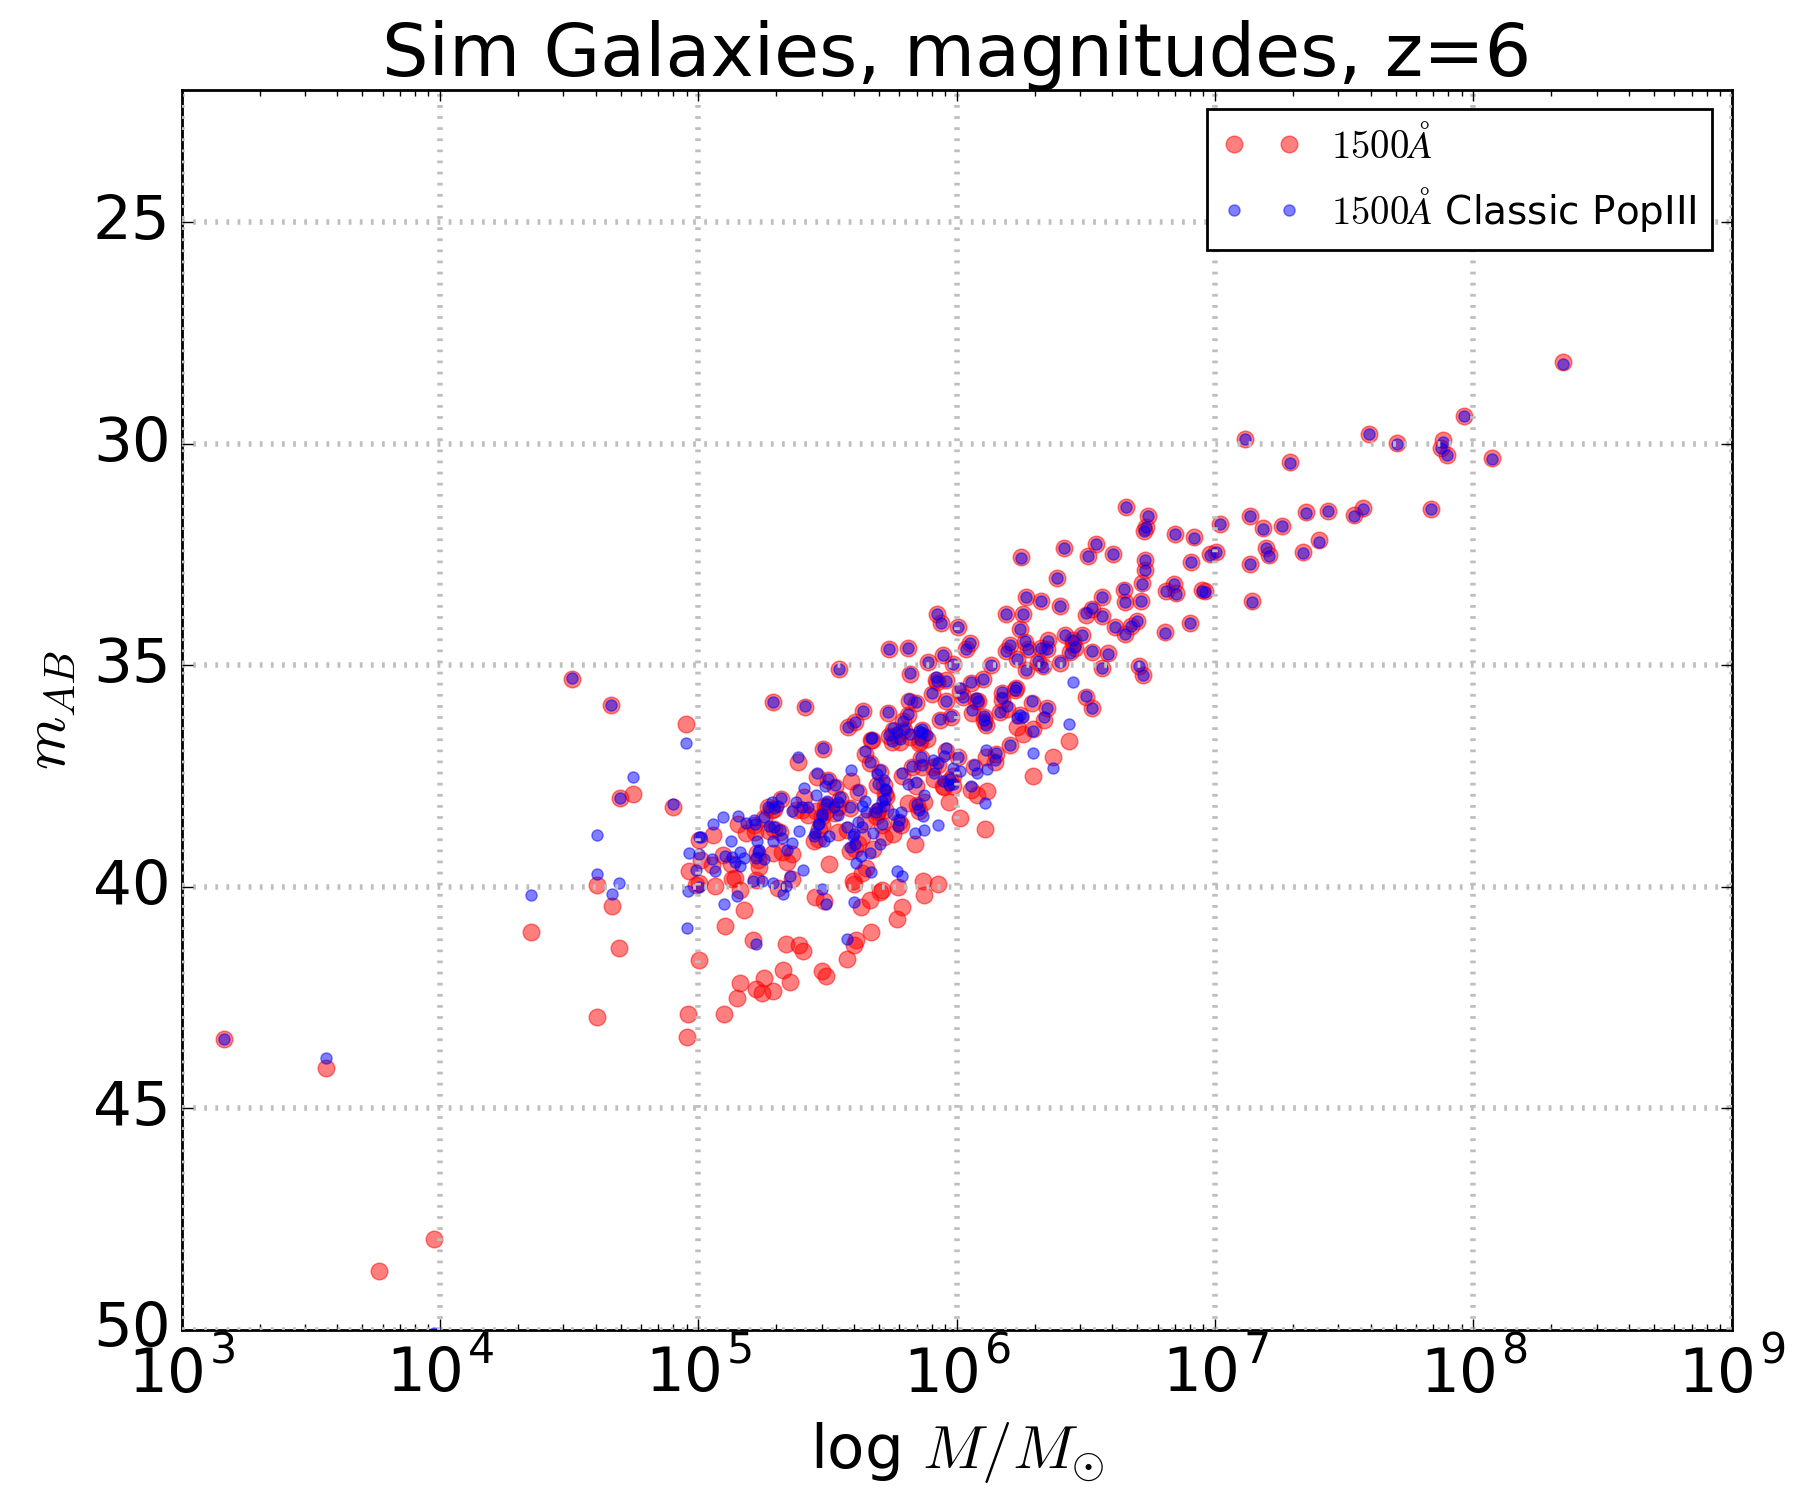

In [8]:
z=6

haloNums = range(len(fluxes[z]['1500A_restFlux']))
pylab.rcParams.update({'font.size': 22, 'text.usetex': False})
fig = plt.figure(figsize=(10,8))
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('linear')

ax.set_title('Sim Galaxies, magnitudes, z={}'.format(z))
# ax.errorbar(haloNums,mag(fluxes[z]['f277w']),yerr=f277wErr,fmt='r.',markersize=22,alpha=0.5)
ax.plot(fluxes[z]['MM_sun'],mag(fluxes[z]['1500A_restFlux']),'r.',markersize=12,alpha=0.5,label='$1500\AA$')
ax.plot(fluxes[z]['MM_sun'],mag(fluxes[z]['1500A_restFlux_NM']),'b.',markersize=8,alpha=0.5,label='$1500\AA$ Classic PopIII')

ax.set_ylim([22,50])
ax.set_xlabel('log $M/M_{\odot}$')
ax.set_ylabel(r'$m_{AB}$')
ax.grid(color='0.75', linestyle=':', linewidth=2)

ax.legend(loc='upper right', fontsize=14 )
# ax.text('Large dots indicate PopIII only magnitude', 
#             textcoords='axes fraction', xy=(.5,.5), xytext=(.01,.95),size=14)

plt.gca().invert_yaxis()
plt.savefig("haloMag_{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()


__Setup the magnitude bis for the schechter fits__

In [9]:
# LIMITING MAGNITUDE TO CONSIDER FOR FITS
limitM = -10
pwrLawMinM = -10
magBins = np.linspace(-24,limitM,limitM+24+1) 
pwrLawMagBins = np.linspace(-24,pwrLawMinM,pwrLawMinM+24+1)
magBins,pwrLawMagBins

(array([-24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
        -13., -12., -11., -10.]),
 array([-24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
        -13., -12., -11., -10.]))

In [10]:
simVol = (3.0/0.71)**3

In [11]:
def compMags(z):
    # Convert observed magnitude to Absolute ...
    convertToM = -2.5*np.log10((cosmo.comoving_distance(z)/(10 * u.pc))**2 * (1+z))
    # Or, -5 log (d/10 * (1+z)) ... Need the (1+z) to get to luminosity distance
    print("Convert to Abs Mag - DM = {:.2f} @ z={:.1f}".format(convertToM,z))
    absMag   = mag(fluxes[z]['1500A_restFlux'])+convertToM
    nmAbsMag = mag(fluxes[z]['1500A_restFlux_NM'])+convertToM
    return absMag, nmAbsMag

Convert to Abs Mag - DM = -47.55 @ z=10.0
[-24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.]


21206

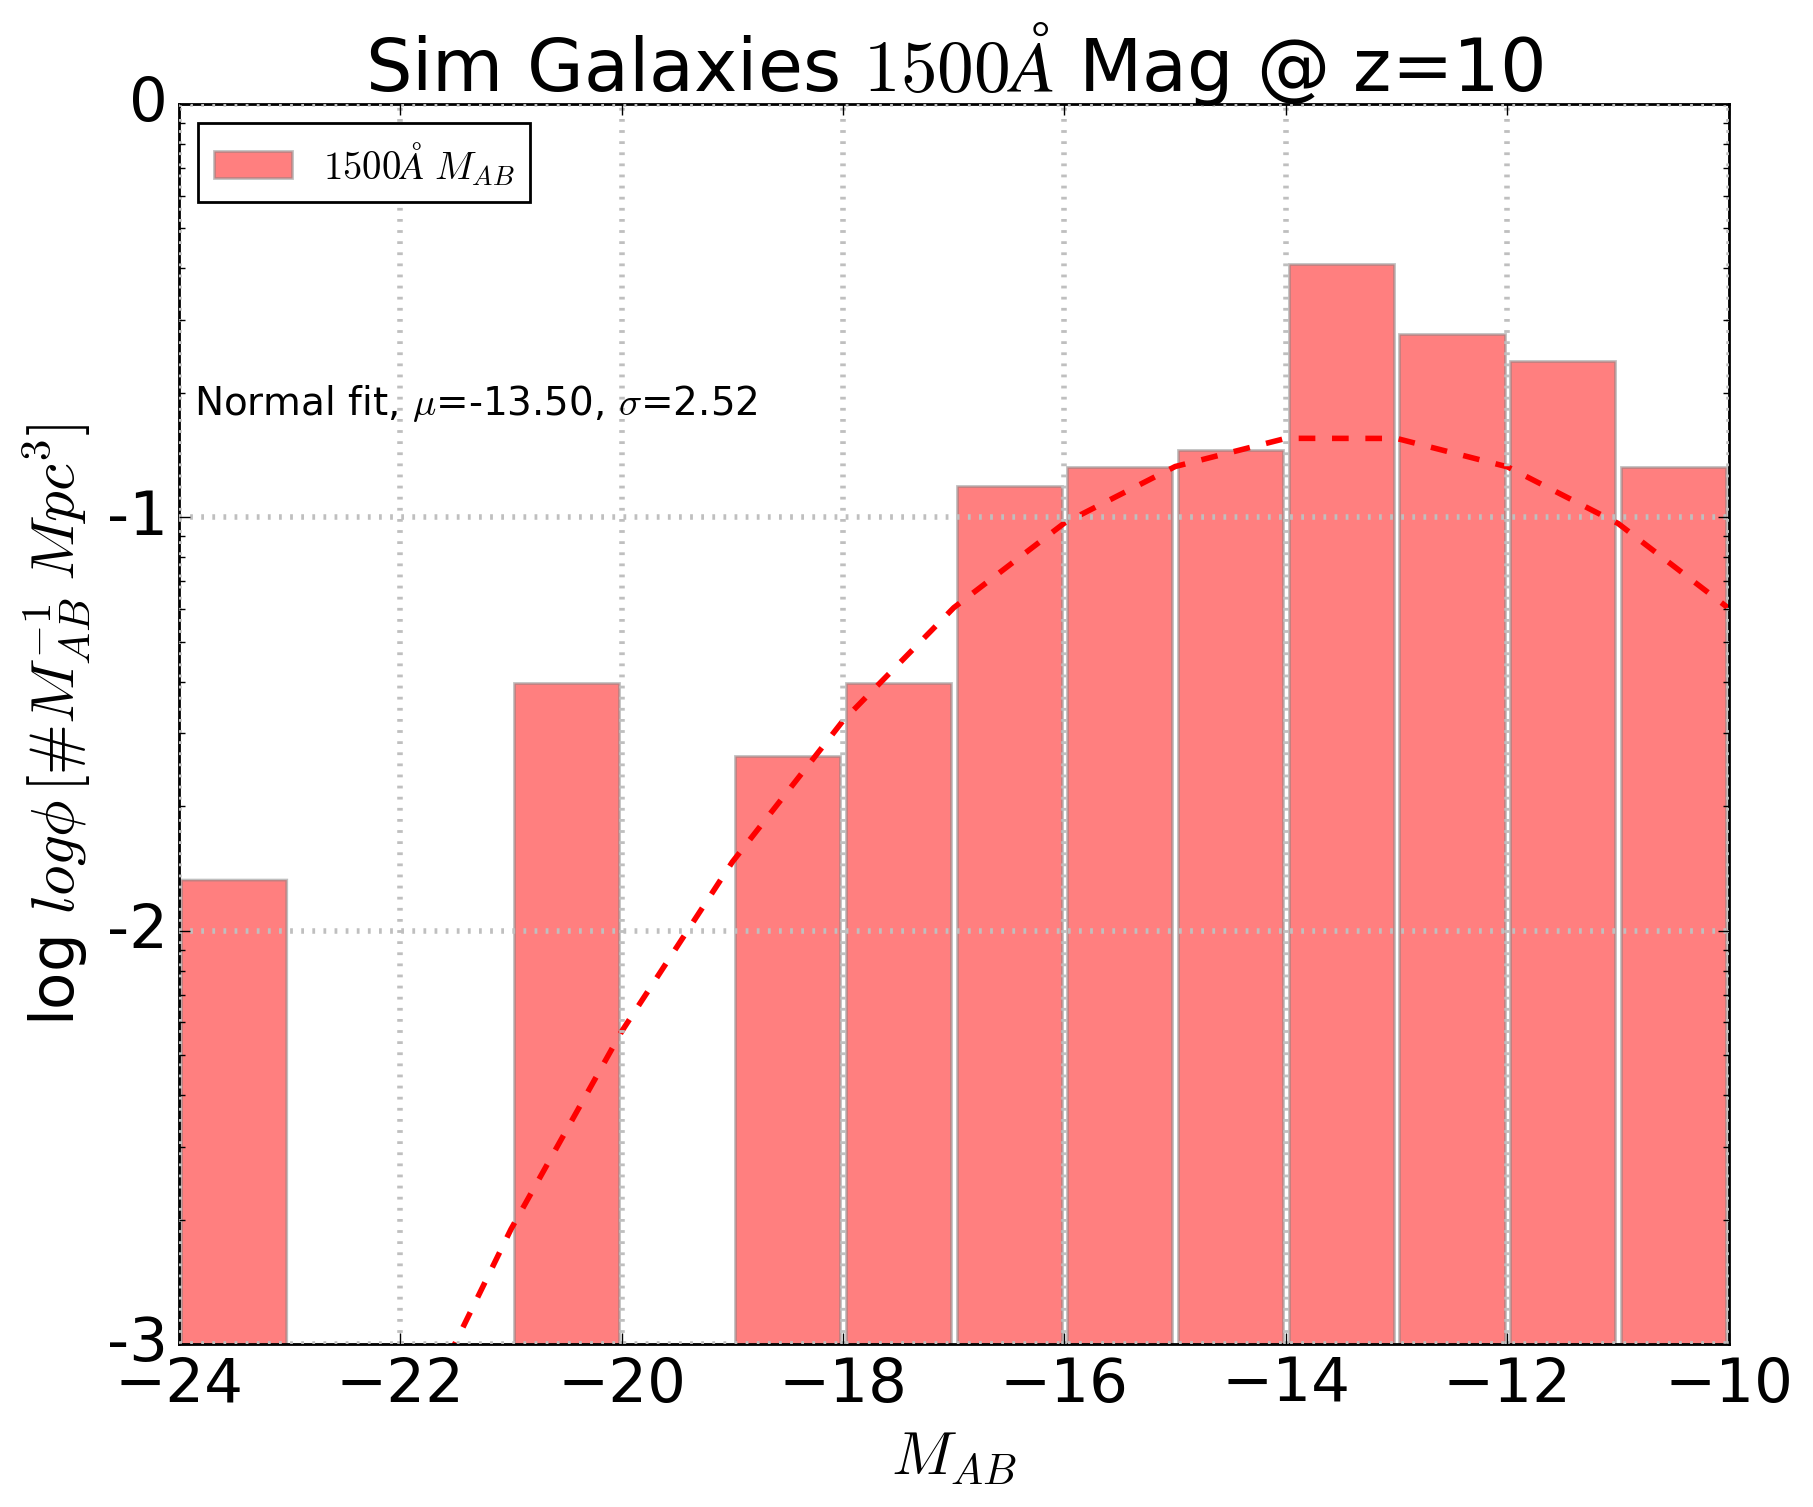

In [12]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes()

z=10
absMag, nmAbsMag = compMags(z)

# Note that our fit is effected by the range of M we choose... 
minMag = absMag.min()
print(magBins)
n, bins, patches = ax.hist(absMag,bins=magBins,log=True, color='r',
                           edgecolor=(0.5,0.5,0.5,0.5), alpha=0.5,rwidth = 0.95,
                           weights=[1.0/simVol for i in absMag]) 

ax.legend(['$1500\AA\;M_{AB}$','$1500\AA\;M_{AB}$, No Prist Frac'], 
          loc='upper left', fontsize=14 )

# best fit of data
(mu, sigma) = normDist.fit(absMag,log=False)
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

# (mu, sigma) = norm.fit(nmAbsMag,log=False)
# y = mlab.normDist(bins, mu, sigma)
# l = plt.plot(bins, y, 'b--', linewidth=2)

ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim([-24,limitM])
ax.set_ylim([1e-3,1])
ax.yaxis.set_major_formatter(logfmt)

ax.set_title('Sim Galaxies $1500\AA$ Mag @ z={}'.format(z))
ax.set_xlabel('$M_{AB}$')
ax.set_ylabel(r'log $log \phi\, [\# M_{AB}^{-1}\; Mpc^3]$')
ax.grid(color='0.75', linestyle=':', linewidth=2)

ax.annotate(r'Normal fit, $\mu$={:.2f}, $\sigma$={:.2f}'.format(mu,sigma), 
                    xycoords='axes fraction', textcoords='axes fraction', xy=(.65,.5), xytext=(.01,.75),size=14)


#     plt.gca().invert_xaxis()
plt.savefig("haloZVs1500Mag_{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()


In [13]:
## plt.xkcd(True)

**Use numpy to compute the histogram data** 
* _Note that density=False means we're not normalizing the data to create a PDF from the data_

In [14]:
z=10
# compute M for our data
absMag, nmAbsMag = compMags(z)

# a, bins=10, range=None, density=False, weights=None, density=None
n, bins = np.histogram(absMag,bins=magBins, density=False,
                                weights=[1.0/simVol for i in absMag]) 

# Plot range for analytic functions... 
rgForSFunc = np.arange(-24,limitM, 0.1)

# Assoc bin center with value from histogram... 
binDelta = (bins[0]-bins[1])/2.0
binCenters = bins[1::]+binDelta

print("Bin values from data: ",n)
print("Bin centers:",binCenters[binCenters < limitM])

Convert to Abs Mag - DM = -47.55 @ z=10.0
Bin values from data:  [ 0.01325596  0.          0.          0.03976789  0.          0.02651193
  0.03976789  0.11930367  0.13255963  0.14581559  0.41093485  0.27837522
  0.23860733  0.13255963]
Bin centers: [-23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5
 -11.5 -10.5]


In [15]:
# Schechter values from Finkelstein, 2016
# Phi*, alpha, M*
finkel = {
    5: [10**-3.18,-1.8,-20.92],
    6: [10**-3.37,-1.91,-20.79],
    7: [10**-3.56,-2.02,-20.66],
    8: [10**-3.75,-2.13,-20.52],
    9: [10**-3.94,-2.24,-20.39],
    10:[10**-4.13,-2.35,-20.25]
}

In [16]:
# phiStar=1.46e-2, MStar=-20.79, alpha=-1.2 from Finkelstein
# From mathematica fit for z=10 data - Use to check this fit... 
# \[Phi]star -> 0.16573, \[Alpha] -> -1.18934, Mstar -> -17.1986
def schechterM_forFit(params, magnitude):
    """Schechter luminosity function by magnitudes."""
    phiStar = params[0]
    alpha   = params[1]
    MStar   = params[2]
    MStarMinM = 0.4 * (MStar - magnitude)
    return (0.4 * np.log(10) * phiStar *
            10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))


# phiStar=1.46e-2, MStar=-20.79, alpha=-1.2 from Finkelstein
# From mathematica fit for z=10 data - Use to check this fit... 
# \[Phi]star -> 0.16573, \[Alpha] -> -1.18934, Mstar -> -17.1986
def pwrLaw_forFit(params, magnitude):
    """Schechter luminosity function by magnitudes."""
    phiStar = params[0]
    alpha   = params[1]
    MStar   = params[2]
    MStarMinM = 0.4 * (MStar - magnitude)
    return (phiStar * 10.0**((0.4 * (MStar - magnitude)) * (alpha + 1.)))

In [17]:
# Define an error function: how far are we from the actual data?
# This is what the fit will minimize...
errfuncSchechter = lambda p, mag, y: \
        schechterM_forFit(p,mag) - y # Distance to the target function

p0 = [1.0e-3, -1.0, -21.0] # Initial guess for the parameters
# CHECK THE BIN RANGE... using M brighter than -15 here ... make consistent.
schecFitResults, success = optimize.leastsq(errfuncSchechter, p0, args=(binCenters[binCenters < limitM], n[binCenters < limitM]))
if not success:
    print("UNABLE to fit to Schechter function...")
print("Phi* (scale), alpha (pwr law slope), M* (exp cutoff)")
print("Solution for schechter",schecFitResults)

# Power law only error function
errfuncPwrLaw = lambda p, mag, y: \
        pwrLaw_forFit(p,mag) - y # Distance to the target function

# COMMENT OUT IF YOU DON"T WANT PWR LAW SOLUTION
pwrLawP0 = [1.0e-3, -1.0, -21.0] # Initial guess for the parameters
# CHECK THE BIN RANGE... using M brighter than -15 here ... make consistent.
pwrLawFitResults, success = optimize.leastsq(errfuncPwrLaw, pwrLawP0, args=(binCenters[binCenters < limitM], n[binCenters < limitM]))
if not success:
    print("UNABLE to fit to Pwr Law...")
print("Solution for pwr law",pwrLawFitResults)

Phi* (scale), alpha (pwr law slope), M* (exp cutoff)
Solution for schechter [  0.96296589  -0.41159555 -13.85516024]
Solution for pwr law [  0.05468195  -1.1737859  -20.66508987]


In [18]:
import pymodelfit

ImportError: No module named 'pymodelfit'

In [18]:
#pymodelfit.list_models()

In [19]:
# Create a model of a schechter function... 
# We can use built-in functions to generate a fit... 
from pymodelfit import FunctionModel1DAuto
class SchechterModel(FunctionModel1DAuto):
    def f(self,magnitude,phiStar=1e-3,alpha=-1.1,MStar=-21.0):
        MStarMinM = 0.4 * (MStar - magnitude)
        return (0.4 * np.log(10) * phiStar *
            10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))

ImportError: No module named 'pymodelfit'

In [20]:
# Try using the pymodelfit class...
schechterModel = SchechterModel()
schechterModel.fitData(binCenters, n)

NameError: name 'SchechterModel' is not defined

In [21]:
schechterModel.pardict

NameError: name 'schechterModel' is not defined

In [22]:
schechterModel.plot(logplot='y')


NameError: name 'schechterModel' is not defined

In [23]:
n[binCenters < limitM]

array([ 0.01325596,  0.        ,  0.        ,  0.03976789,  0.        ,
        0.02651193,  0.03976789,  0.11930367,  0.13255963,  0.14581559,
        0.41093485,  0.27837522,  0.23860733,  0.13255963])

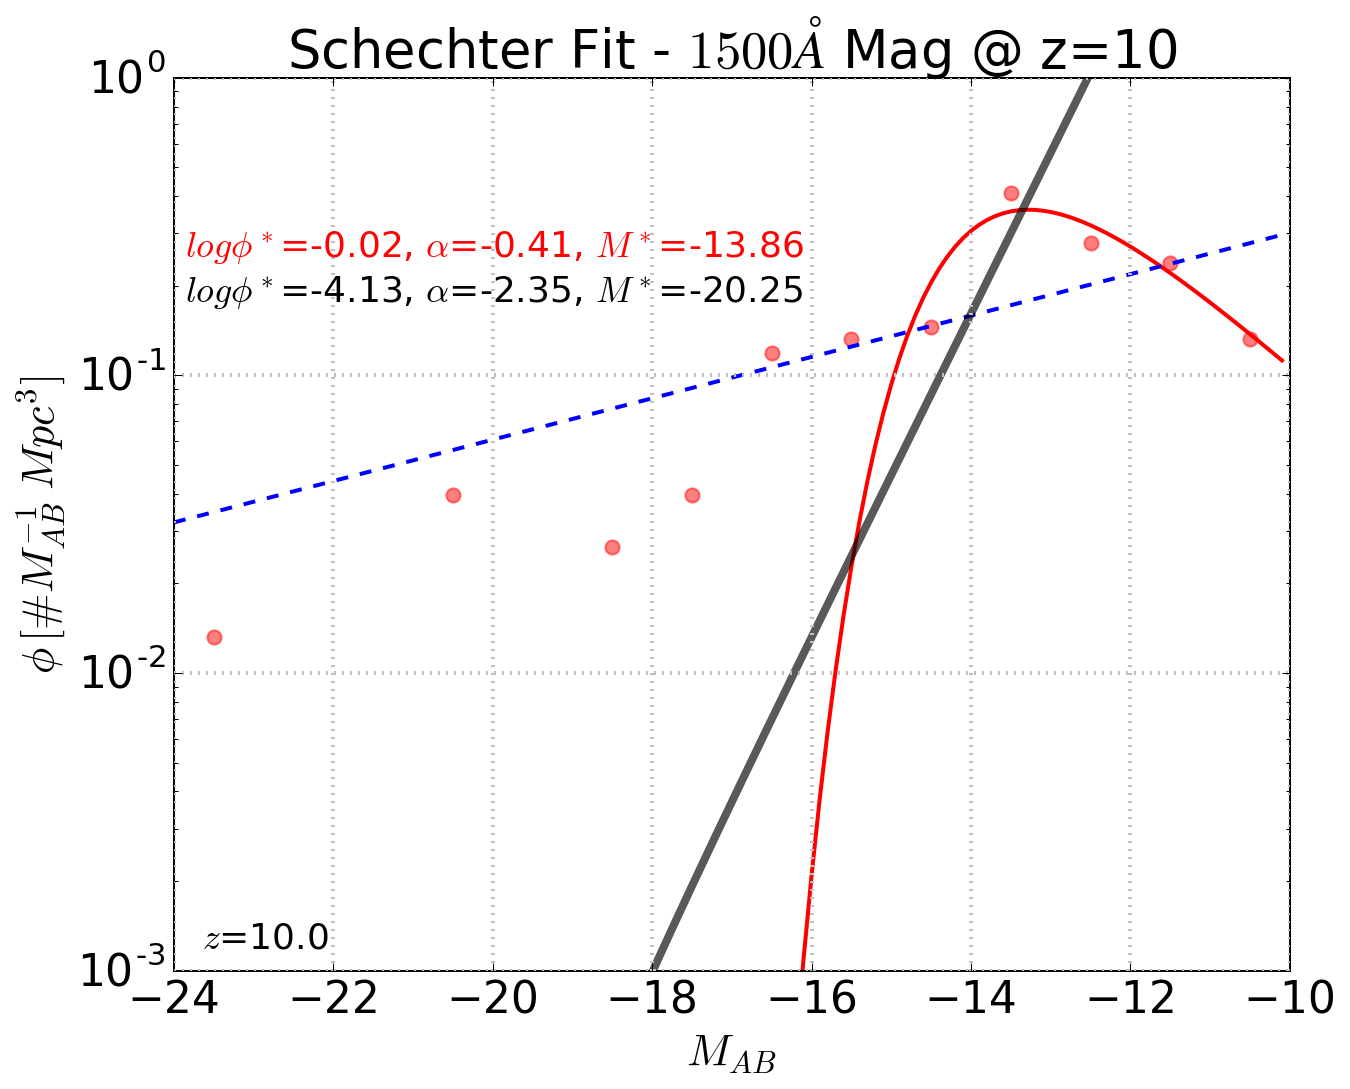

In [24]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes()

# Use the schechter funtion with the solved-for parameters, schecFitResults, to plot the schechter curve
ax.plot(rgForSFunc, schechterM_forFit(schecFitResults, rgForSFunc),'r',lw=2,)
ax.plot(rgForSFunc, pwrLaw_forFit(pwrLawFitResults, rgForSFunc),'b--',lw=2,)
ax.set_yscale('log')
ax.set_xlim([-24,limitM])
ax.set_ylim([1e-3,1e0])

ax.scatter(binCenters[binCenters < limitM], n[binCenters < limitM], color='r', s=50, alpha=0.5) 
ax.set_title('Schechter Fit - $1500\AA$ Mag @ z={}'.format(z))
ax.set_xlabel('$M_{AB}$')
ax.set_ylabel(r'$\phi\, [\# M_{AB}^{-1}\; Mpc^3]$')
ax.grid(color='0.75', linestyle=':', linewidth=2)
ax.annotate(r'$log \phi^*$={:.2f}, $\alpha$={:.2f}, $M^*$={:.2f}'.format(np.log10(schecFitResults[0]),schecFitResults[1],schecFitResults[2]),color='r',
                    xycoords='axes fraction', textcoords='axes fraction', xy=(.5,.5), xytext=(.01,.8),size=18)
if z in finkel.keys():
    ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k',lw=4,alpha=0.65)
    ax.annotate(r'$log \phi^*$={:.2f}, $\alpha$={:.2f}, $M^*$={:.2f}'.format(np.log10(finkel[z][0]),finkel[z][1],finkel[z][2]),
                color='k',xycoords='axes fraction', textcoords='axes fraction', xy=(.5,.5), xytext=(.01,.75),size=18)
ax.annotate(r'$z$={:.1f}'.format(z),color='k',xycoords='axes fraction', textcoords='axes fraction',
            xy=(.1,.1), xytext=(.025,.025),size=18)


Limiting absolute magnitude: -11
Convert to Abs Mag - factor = -46.46
Convert to Abs Mag - DM = -46.46 @ z=5.0
-0.5
[  0.20567161  -1.19272599 -16.40900538]
Convert to Abs Mag - factor = -46.62
Convert to Abs Mag - DM = -46.62 @ z=5.5
-0.5
[  0.15307776  -1.16940273 -17.16601017]
Convert to Abs Mag - factor = -46.76
Convert to Abs Mag - DM = -46.76 @ z=6.0
-0.5
[  0.08677396  -1.35059056 -17.62772729]
Convert to Abs Mag - factor = -46.89
Convert to Abs Mag - DM = -46.89 @ z=6.5
-0.5
[  0.18645863  -1.2890224  -16.37829948]
Convert to Abs Mag - factor = -47.00
Convert to Abs Mag - DM = -47.00 @ z=7.0
-0.5
[  1.89293217e-02  -1.56240330e+00  -1.94308138e+01]
Convert to Abs Mag - factor = -47.11
Convert to Abs Mag - DM = -47.11 @ z=7.5
-0.5
[  3.30530676e-05  -1.70227861e+00  -2.84914347e+01]


/Users/earnric/anaconda/lib/python3.4/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


Convert to Abs Mag - factor = -47.21
Convert to Abs Mag - DM = -47.21 @ z=8.0
-0.5
[  0.11096688 -18.19929534 -12.68580207]
Convert to Abs Mag - factor = -47.31
Convert to Abs Mag - DM = -47.31 @ z=8.5
-0.5
[  0.0332589   -1.38357474 -21.95804484]
Convert to Abs Mag - factor = -47.39
Convert to Abs Mag - DM = -47.39 @ z=9.0
-0.5
[  0.05019681  -1.21949544 -23.43031857]
Convert to Abs Mag - factor = -47.48
Convert to Abs Mag - DM = -47.48 @ z=9.5
-0.5
[  0.02768818  -1.41923391 -19.62323423]
Convert to Abs Mag - factor = -47.55
Convert to Abs Mag - DM = -47.55 @ z=10.0
-0.5
[  0.15171556  -1.20026501 -17.31074368]
Convert to Abs Mag - factor = -47.69
Convert to Abs Mag - DM = -47.69 @ z=11.0
-0.5
[  2.67342714e-05  -1.54820615e+00  -3.16528989e+01]
Convert to Abs Mag - factor = -47.82
Convert to Abs Mag - DM = -47.82 @ z=12.0
-0.5
[  0.04714775  -1.17373414 -19.51660955]
Convert to Abs Mag - factor = -47.94
Convert to Abs Mag - DM = -47.94 @ z=13.0
-0.5
[  1.75045559e-02  -1.21080343e+0

0

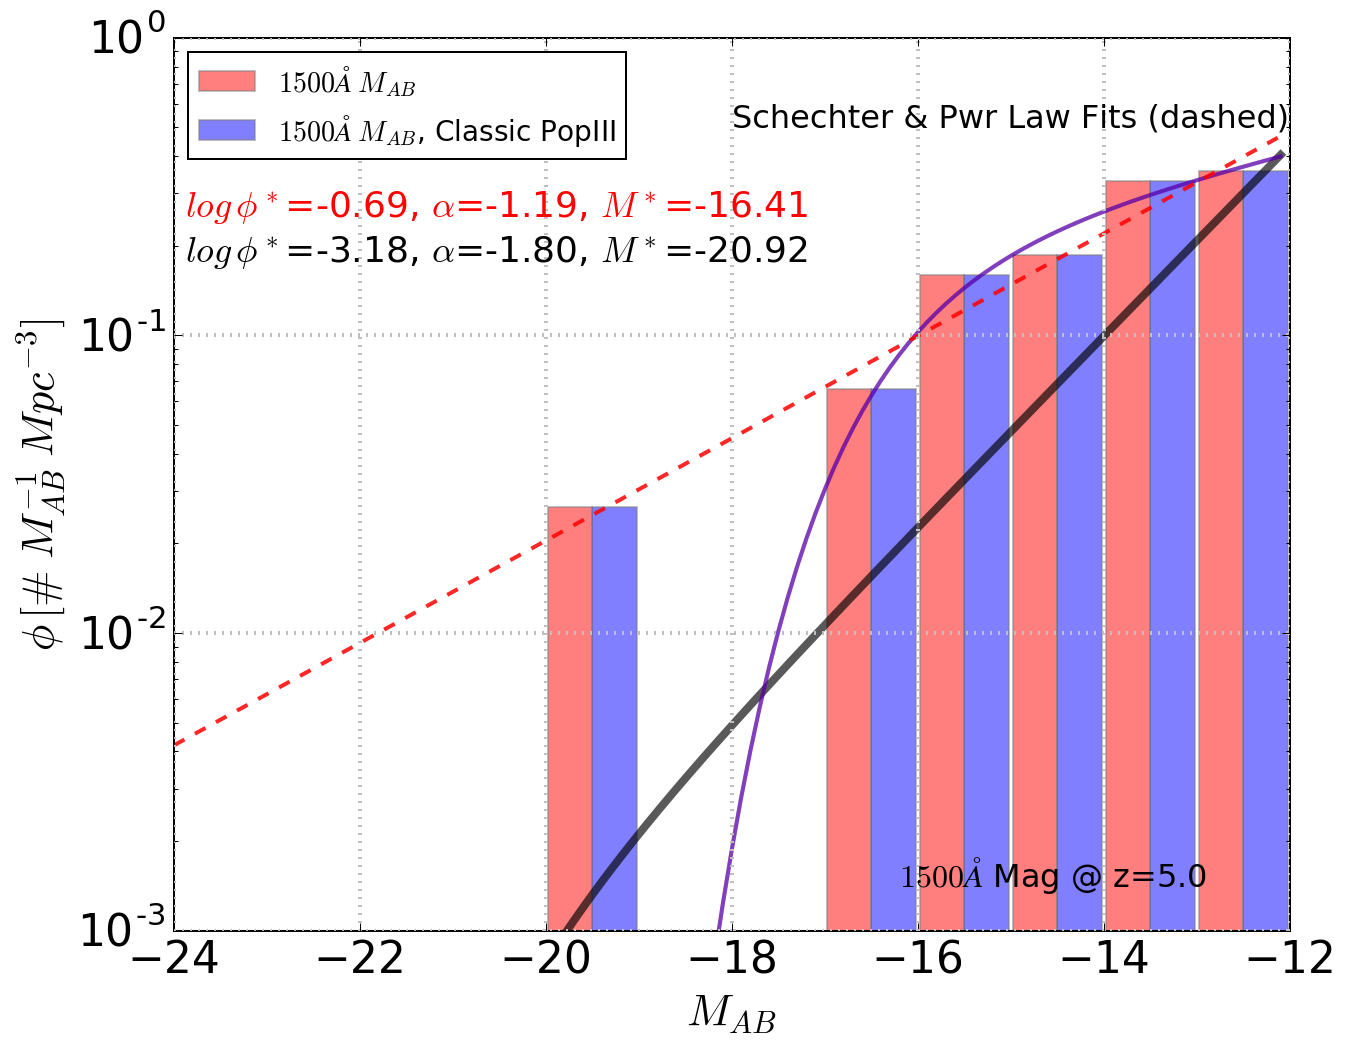

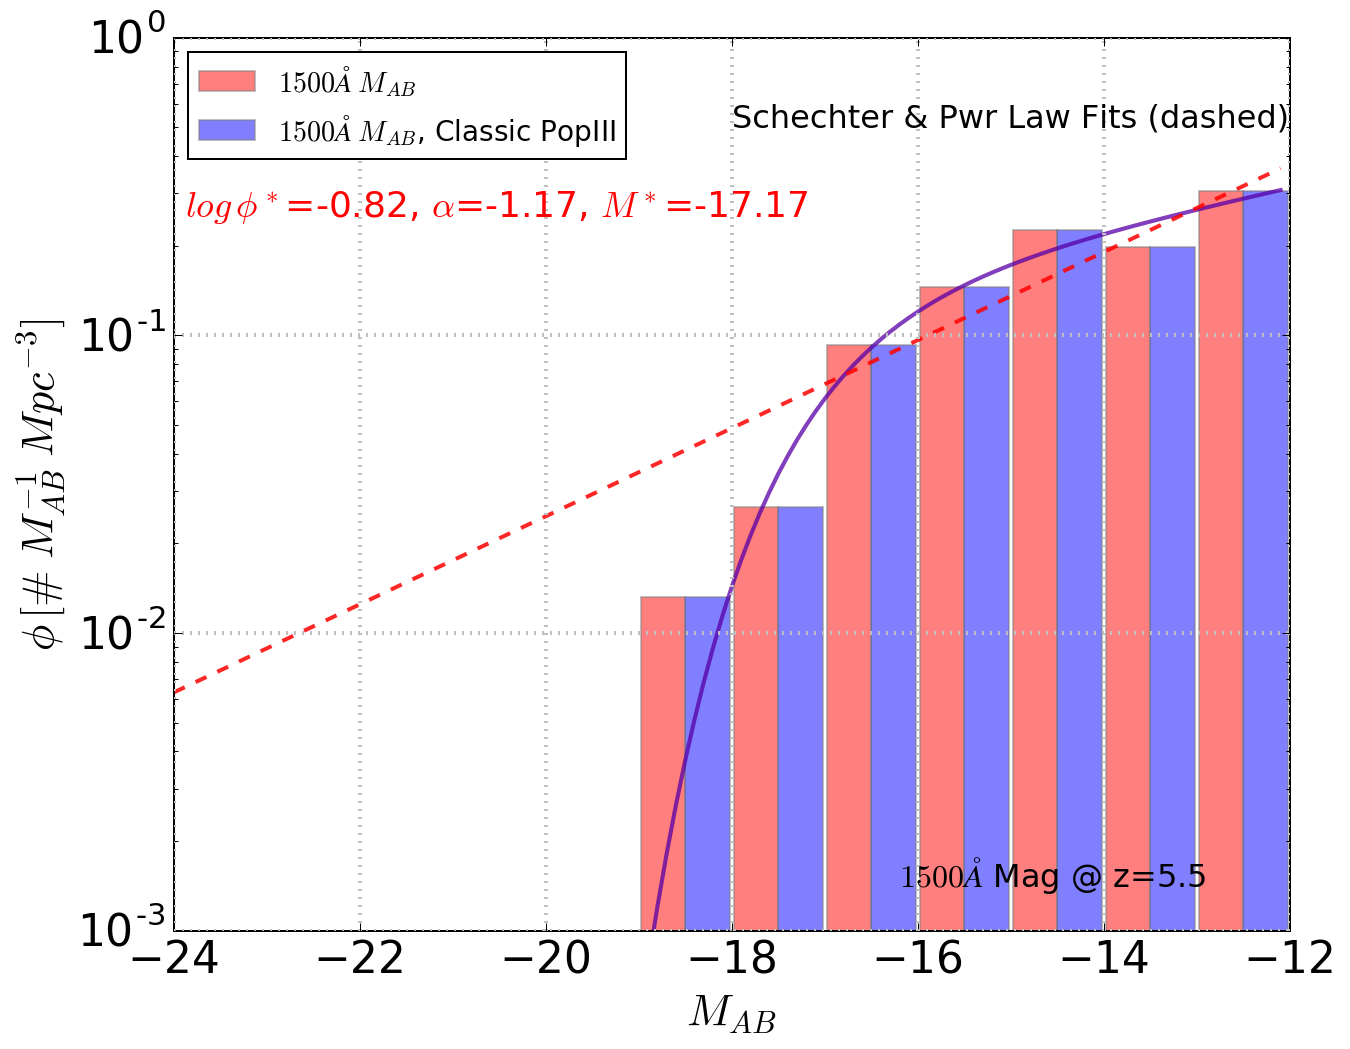

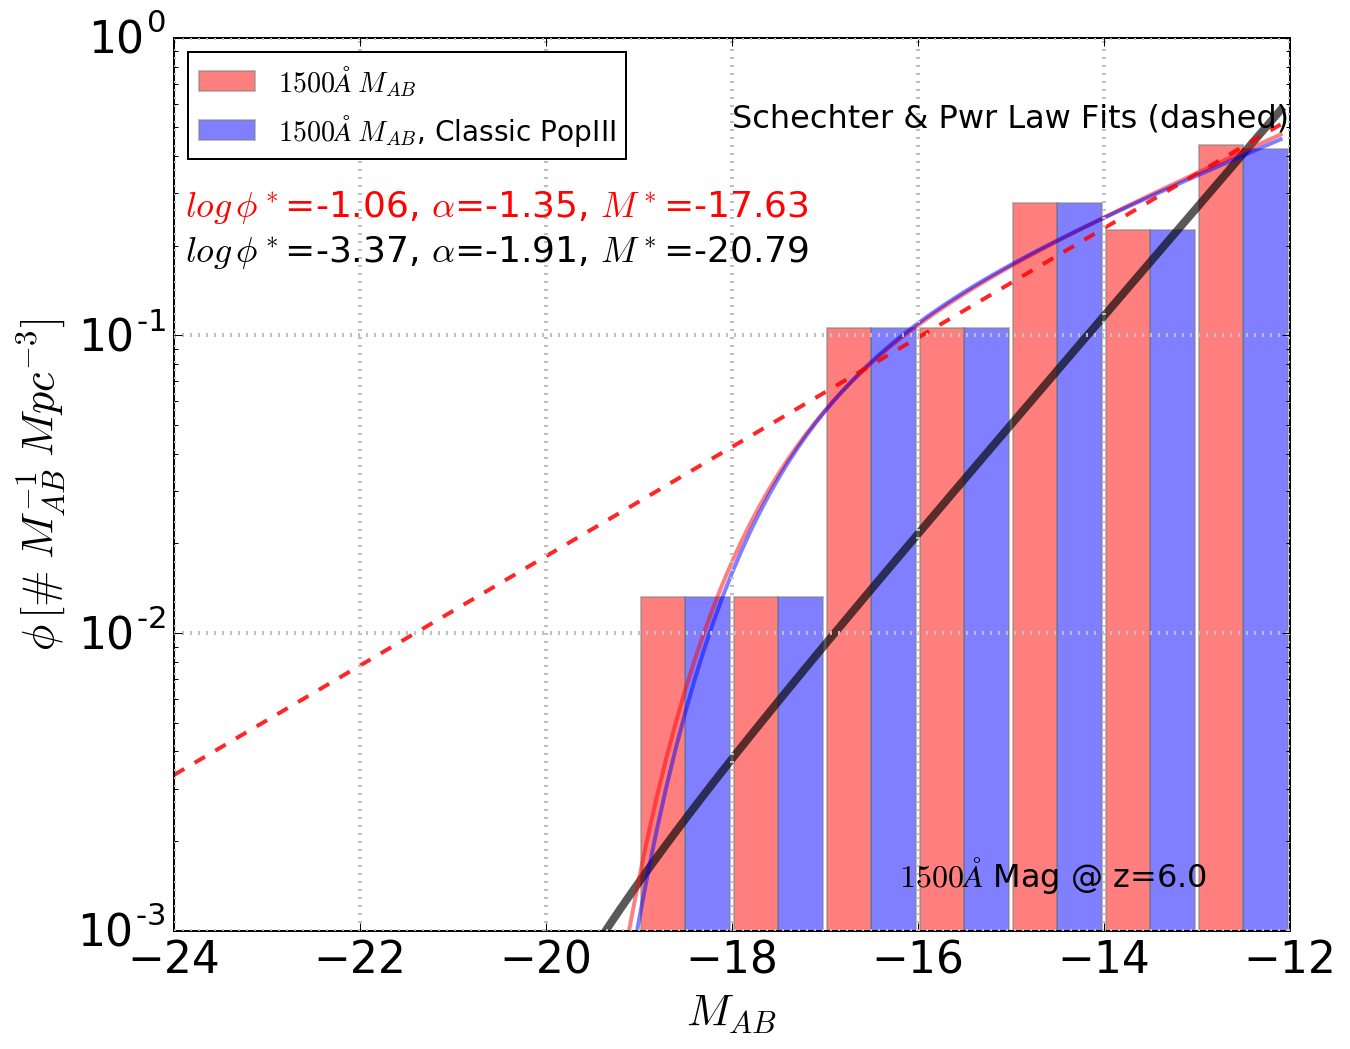

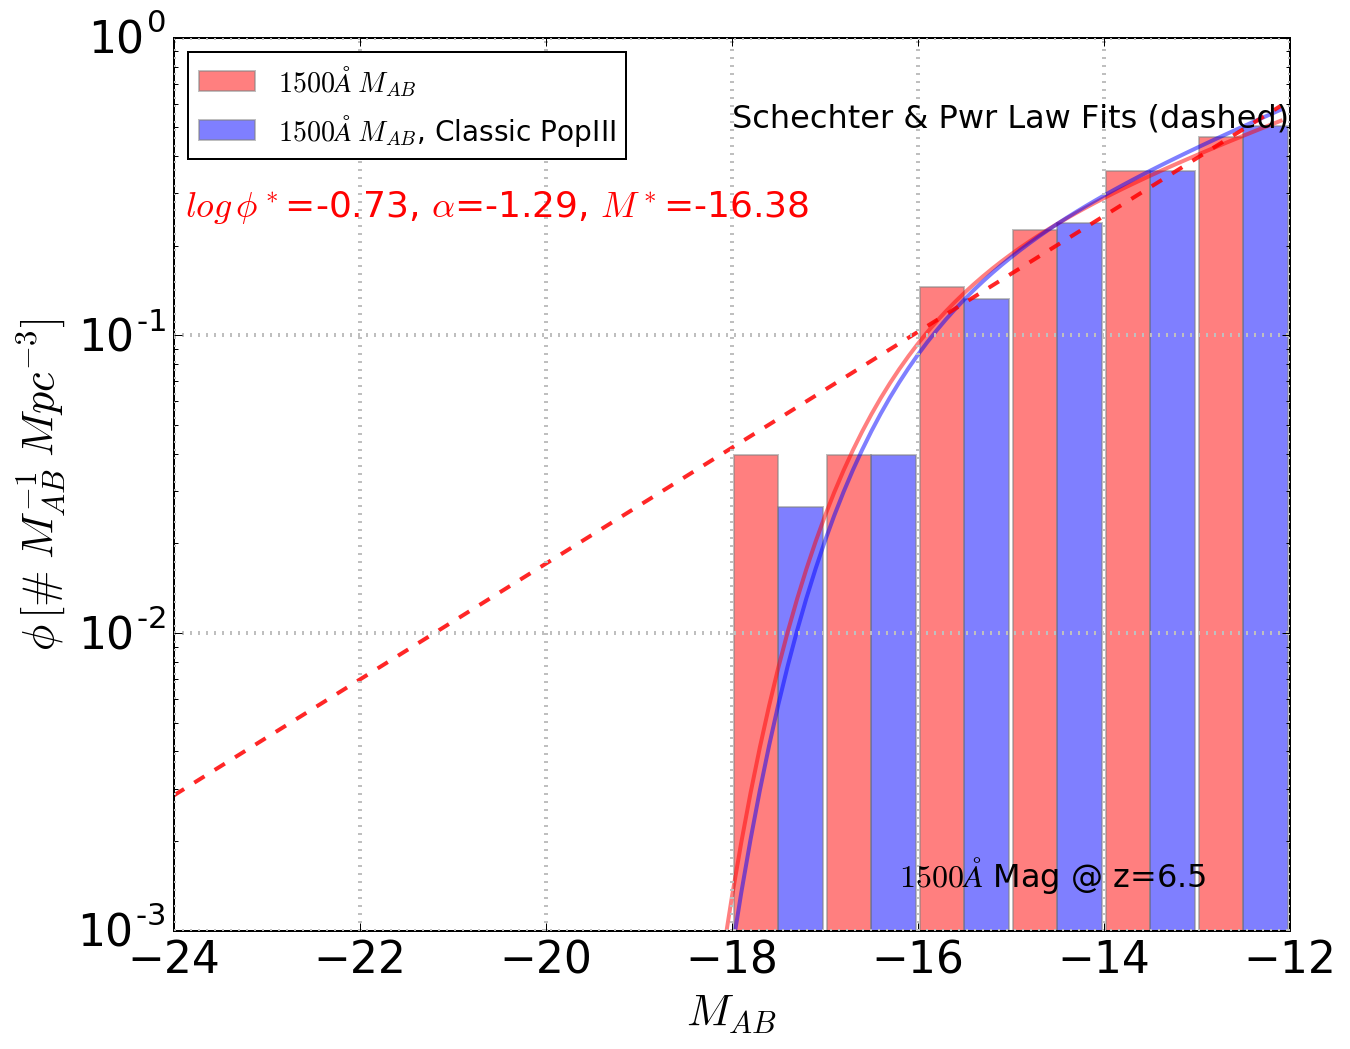

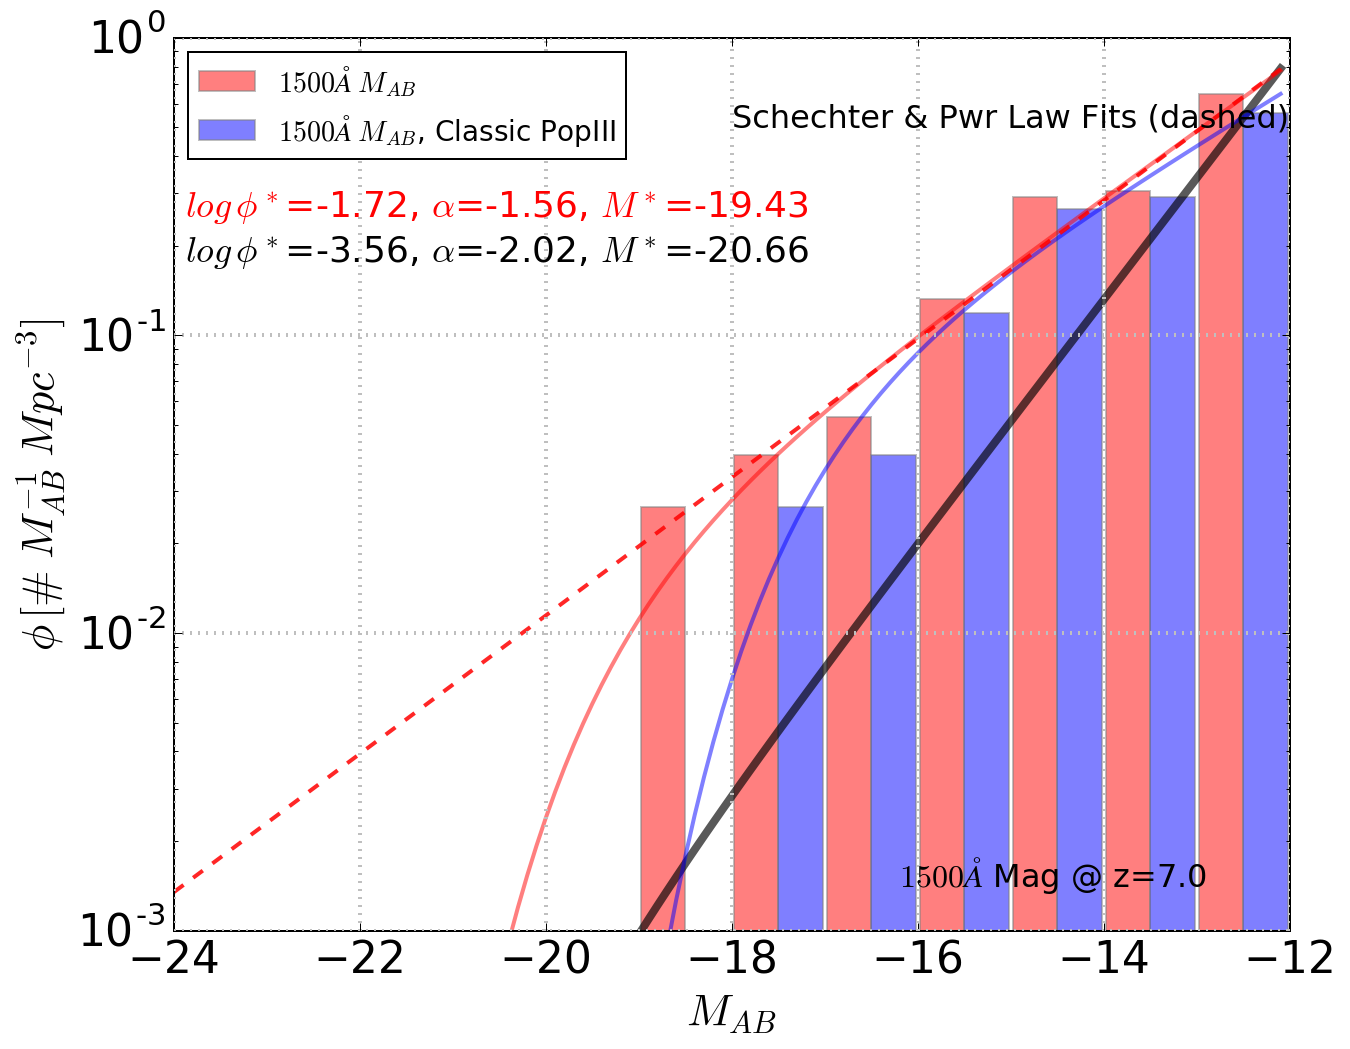

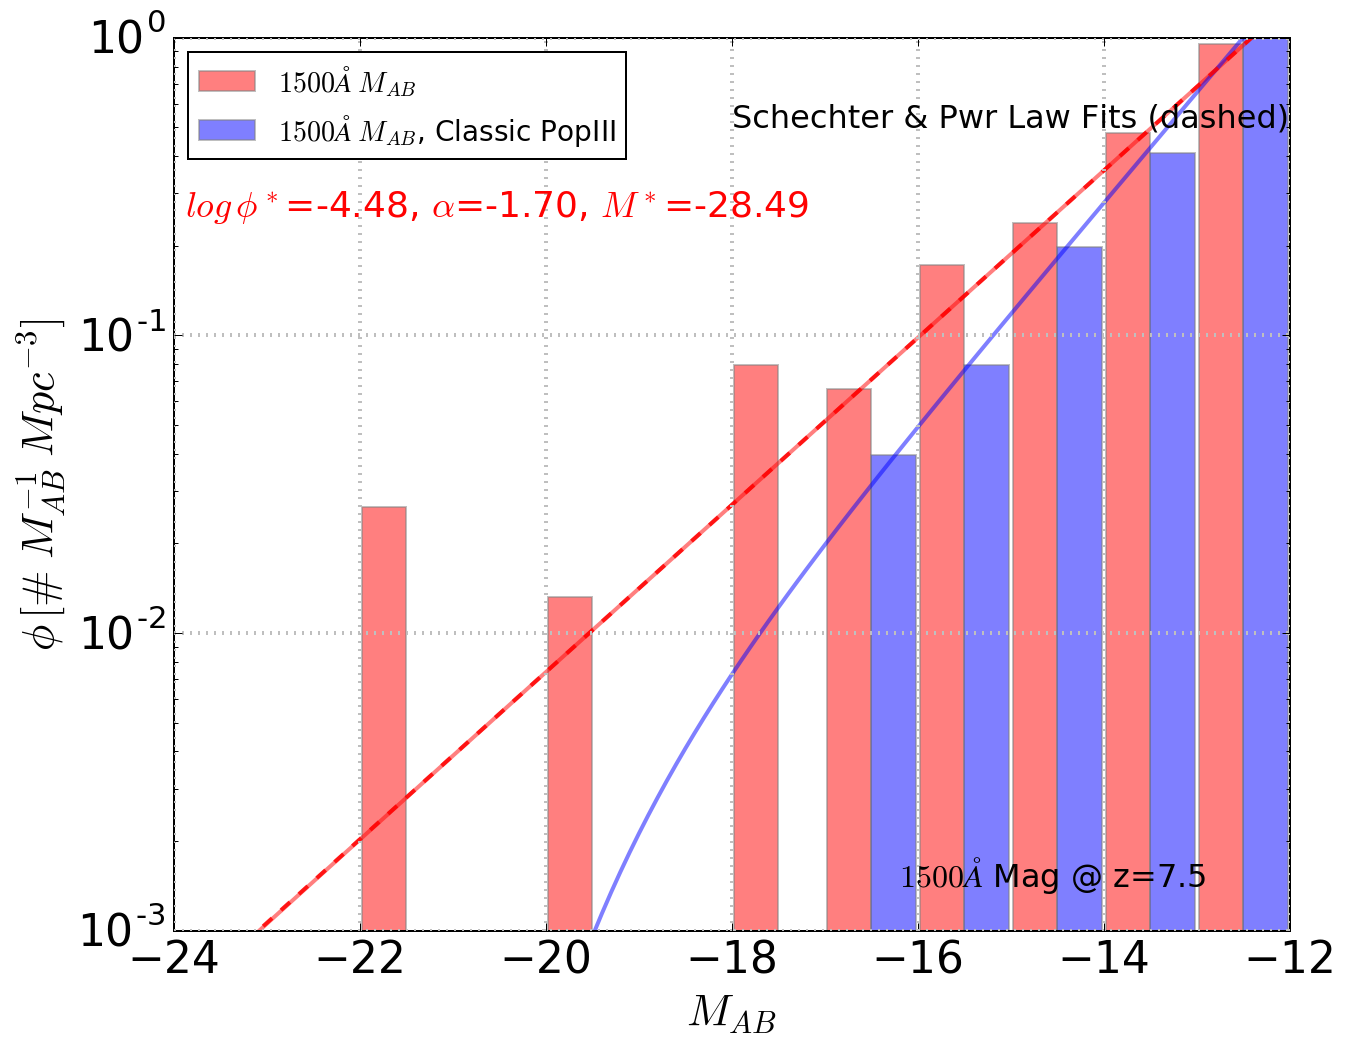

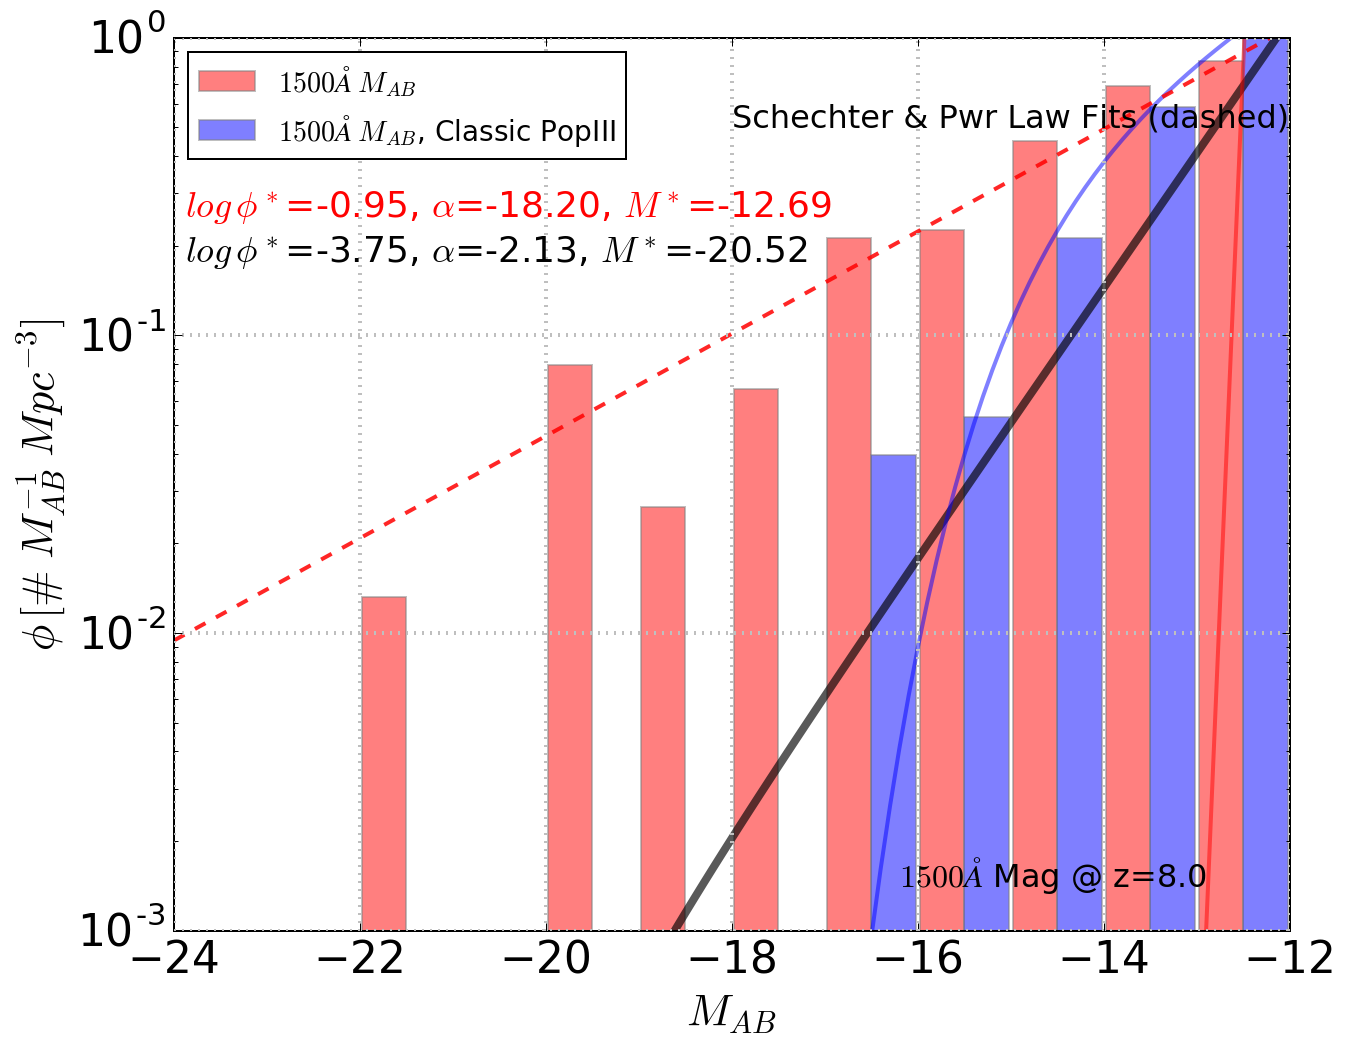

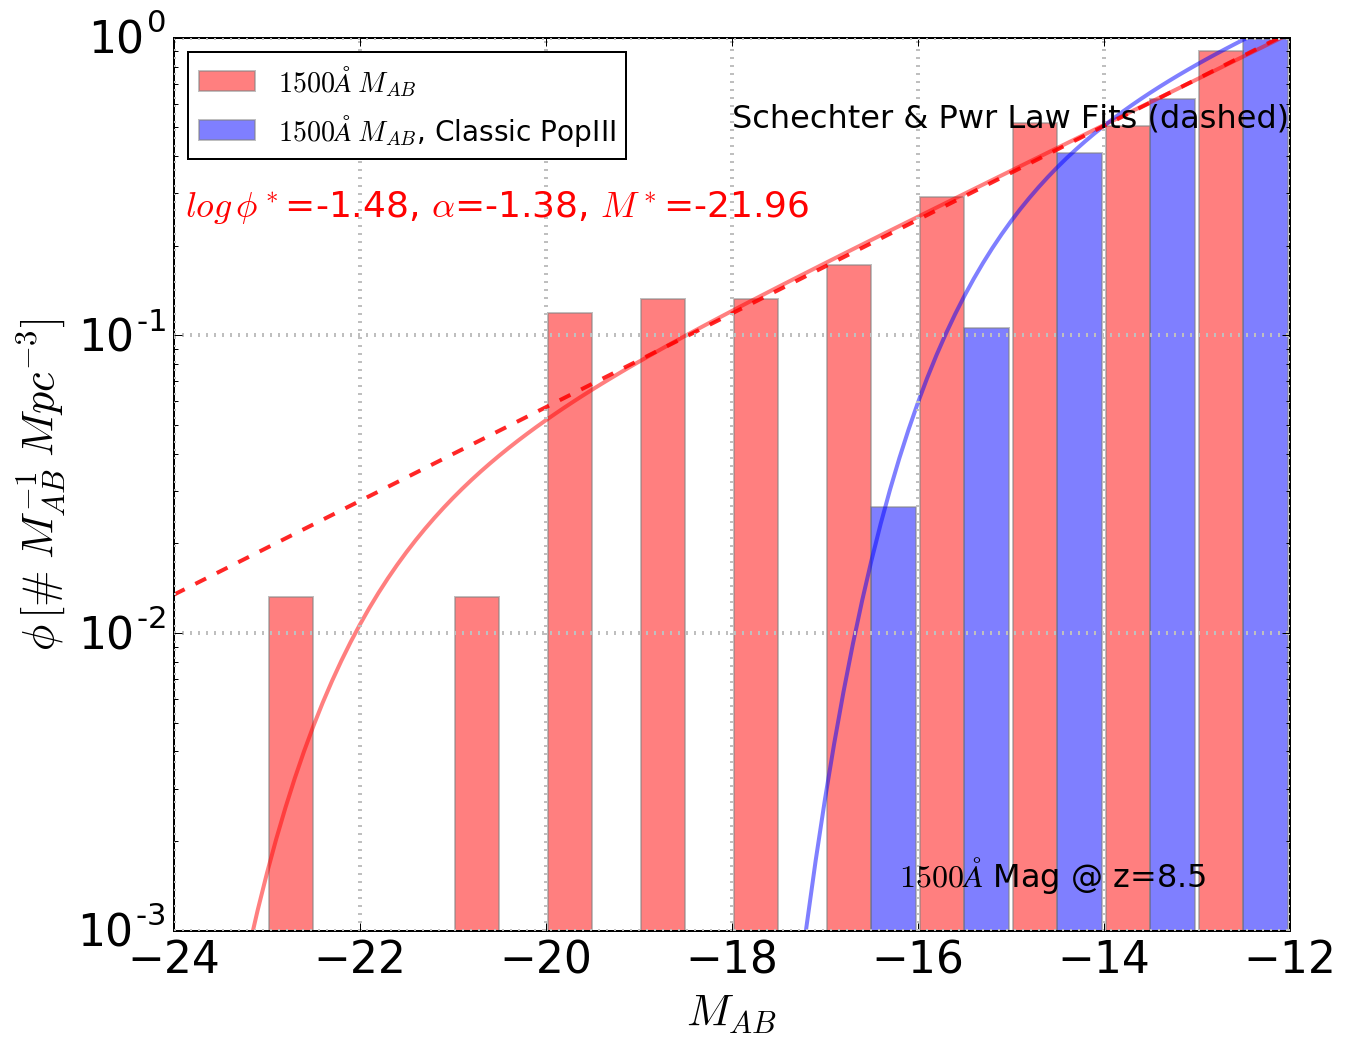

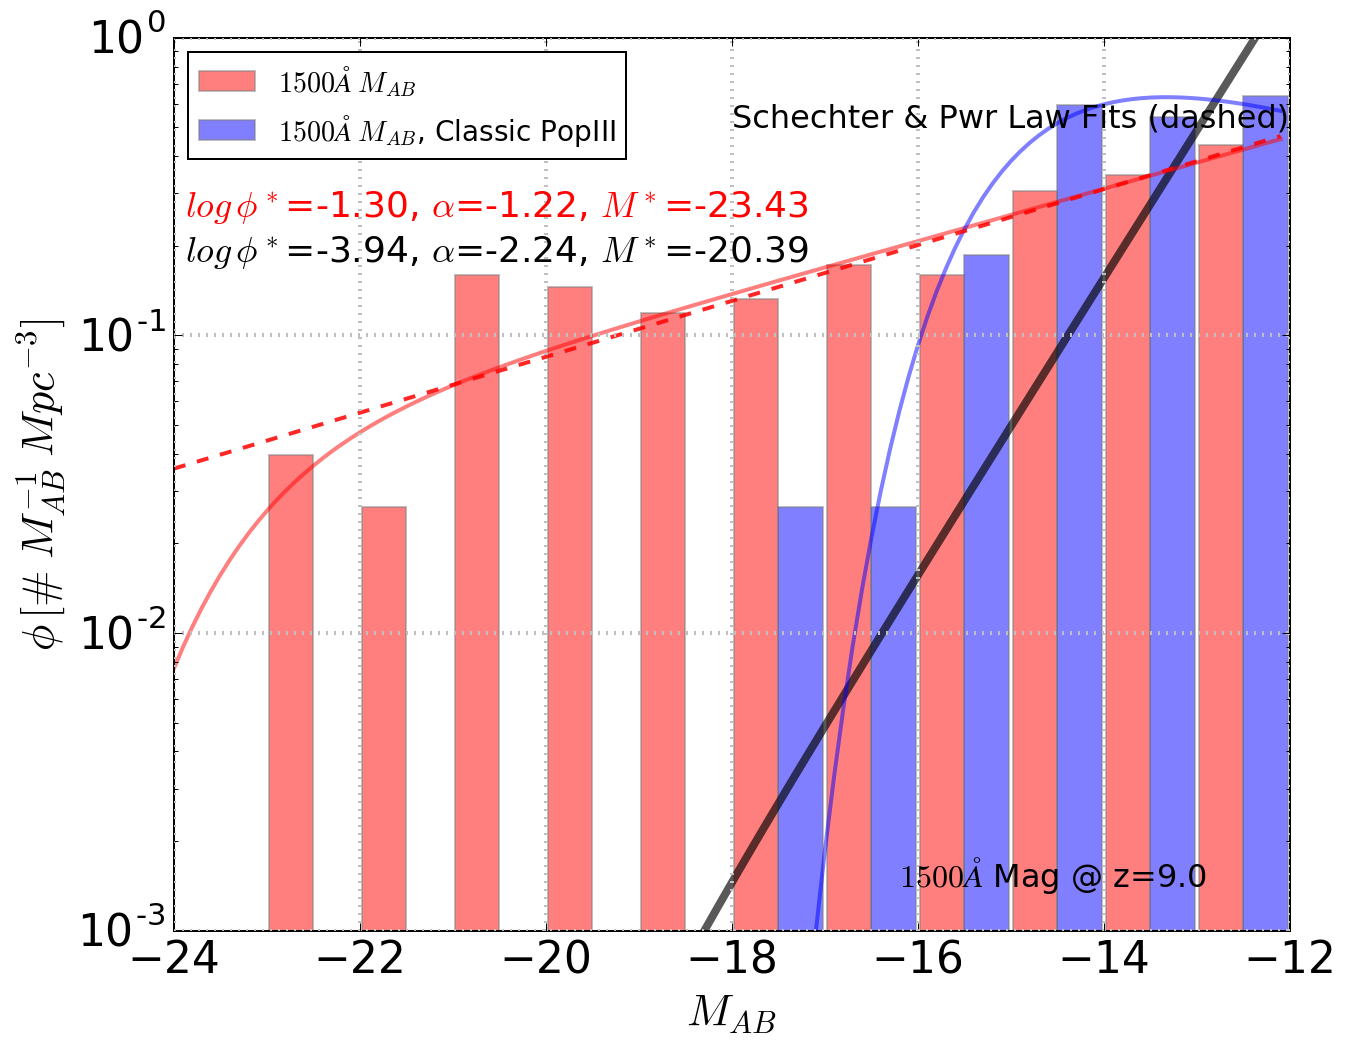

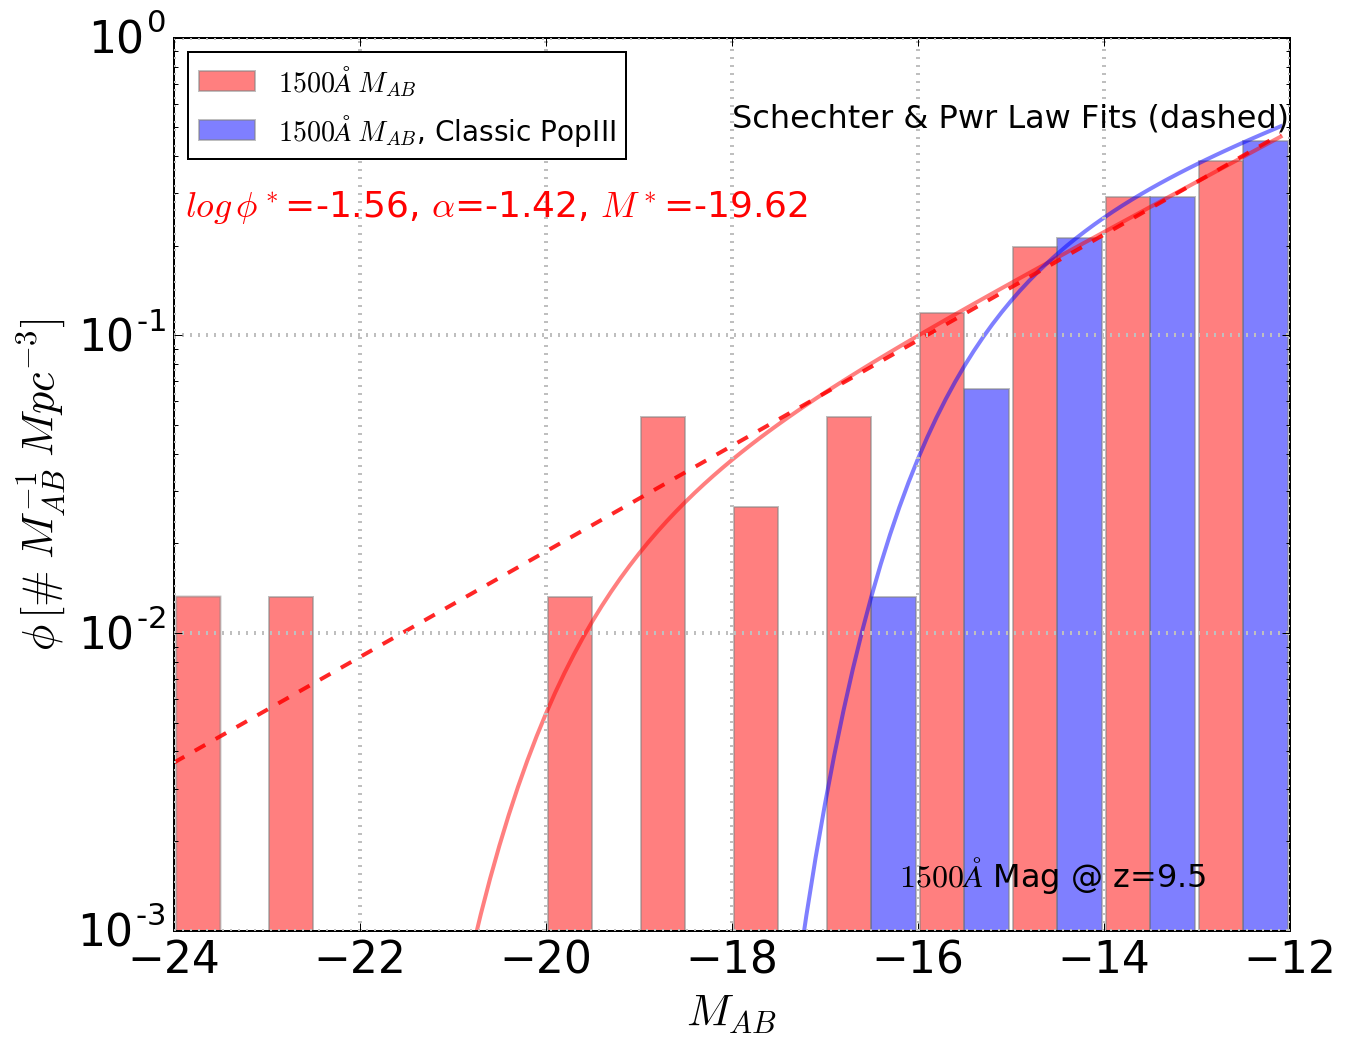

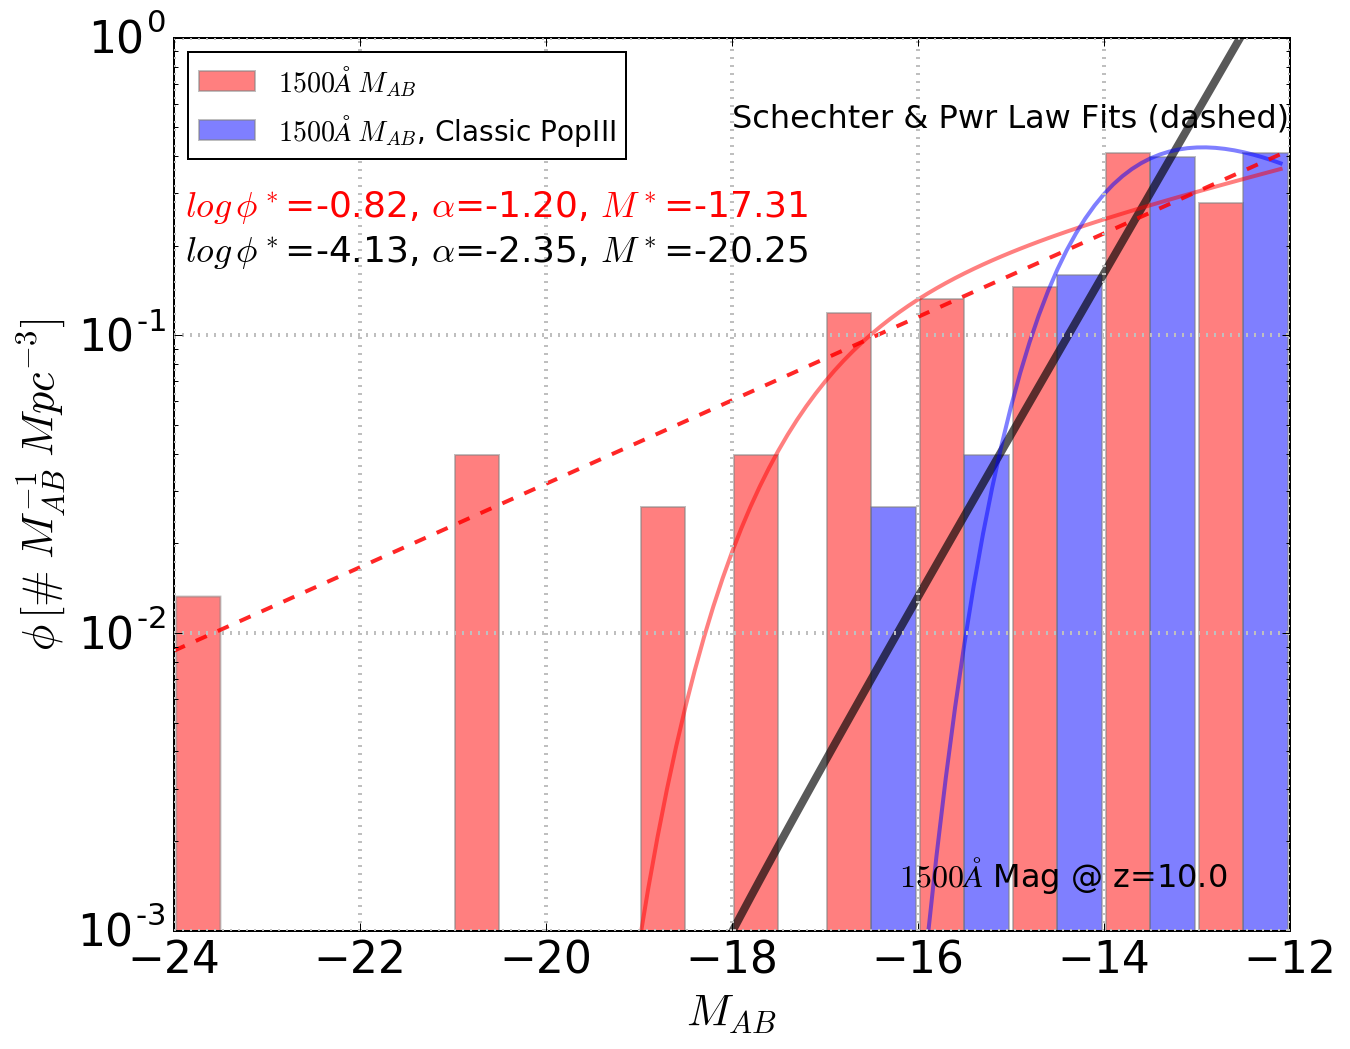

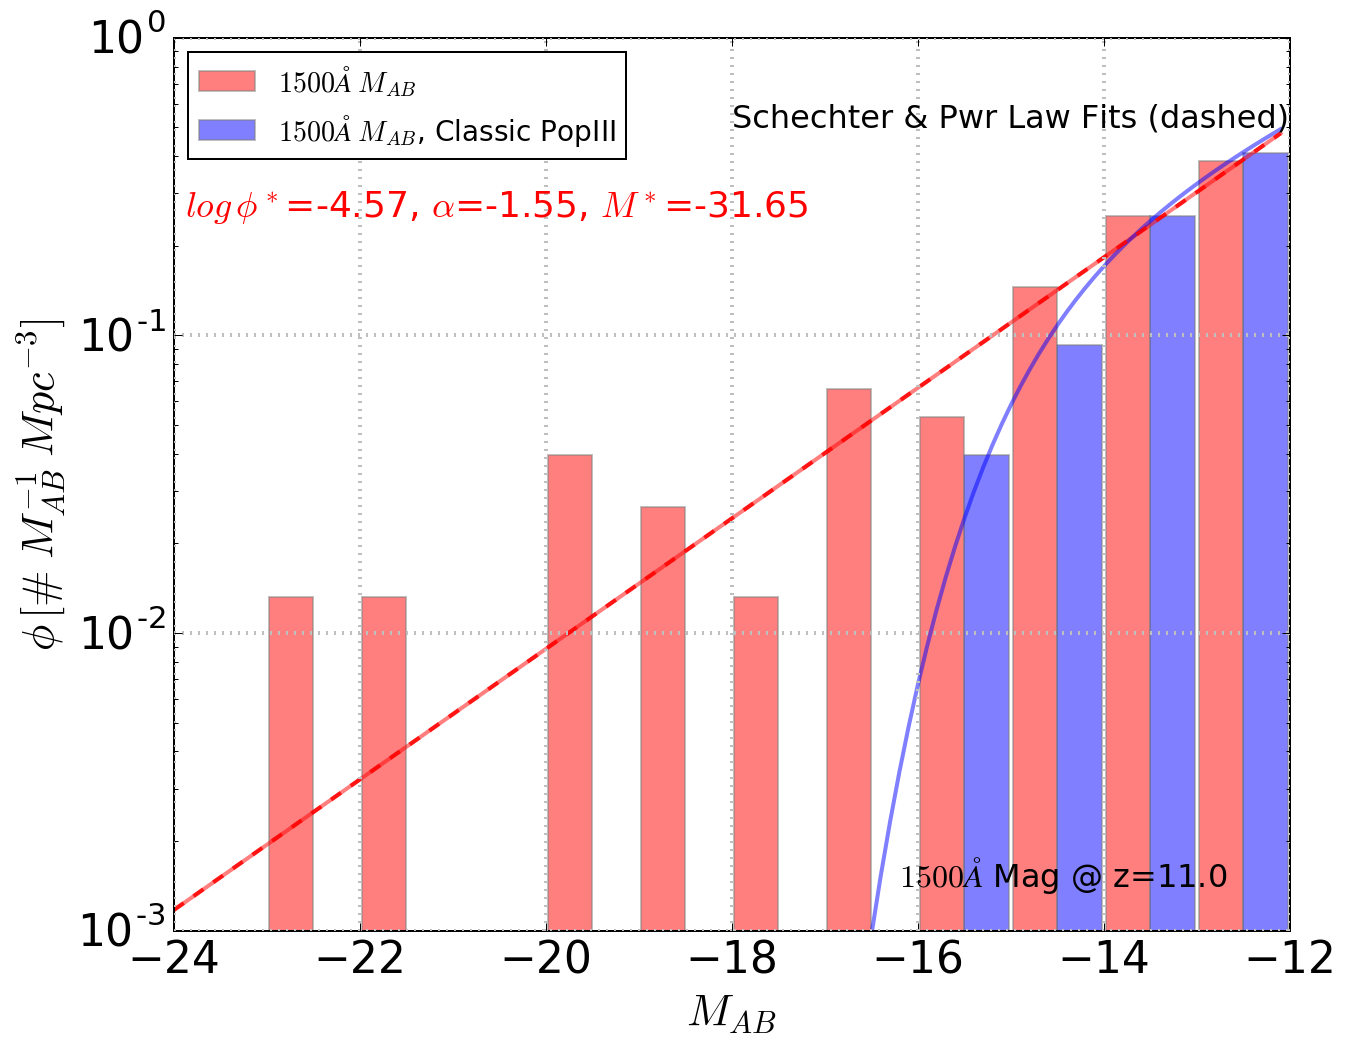

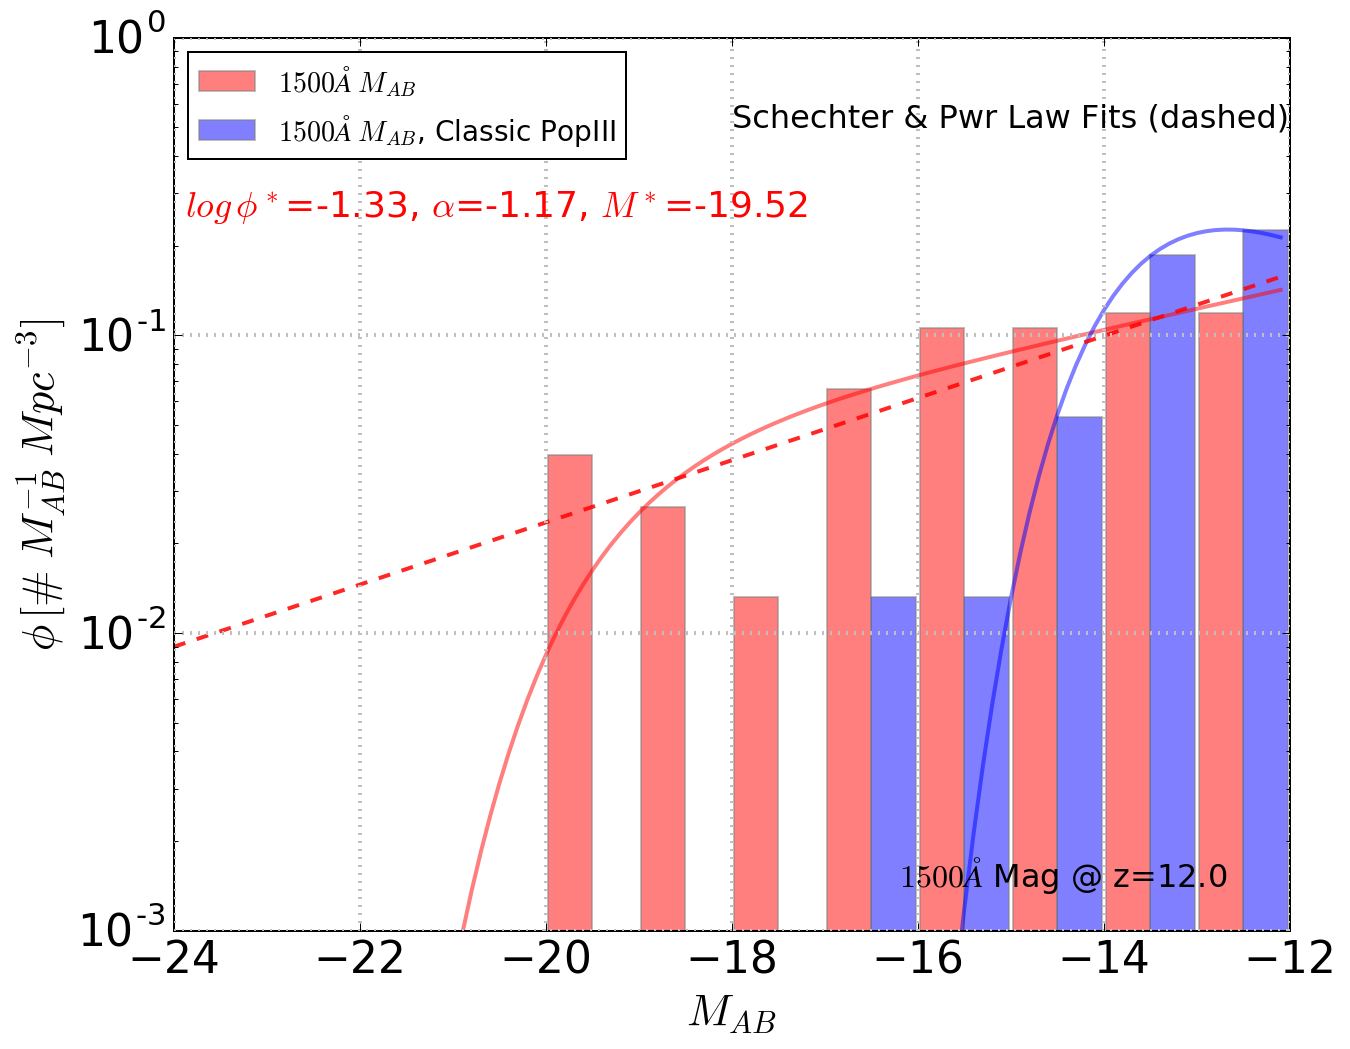

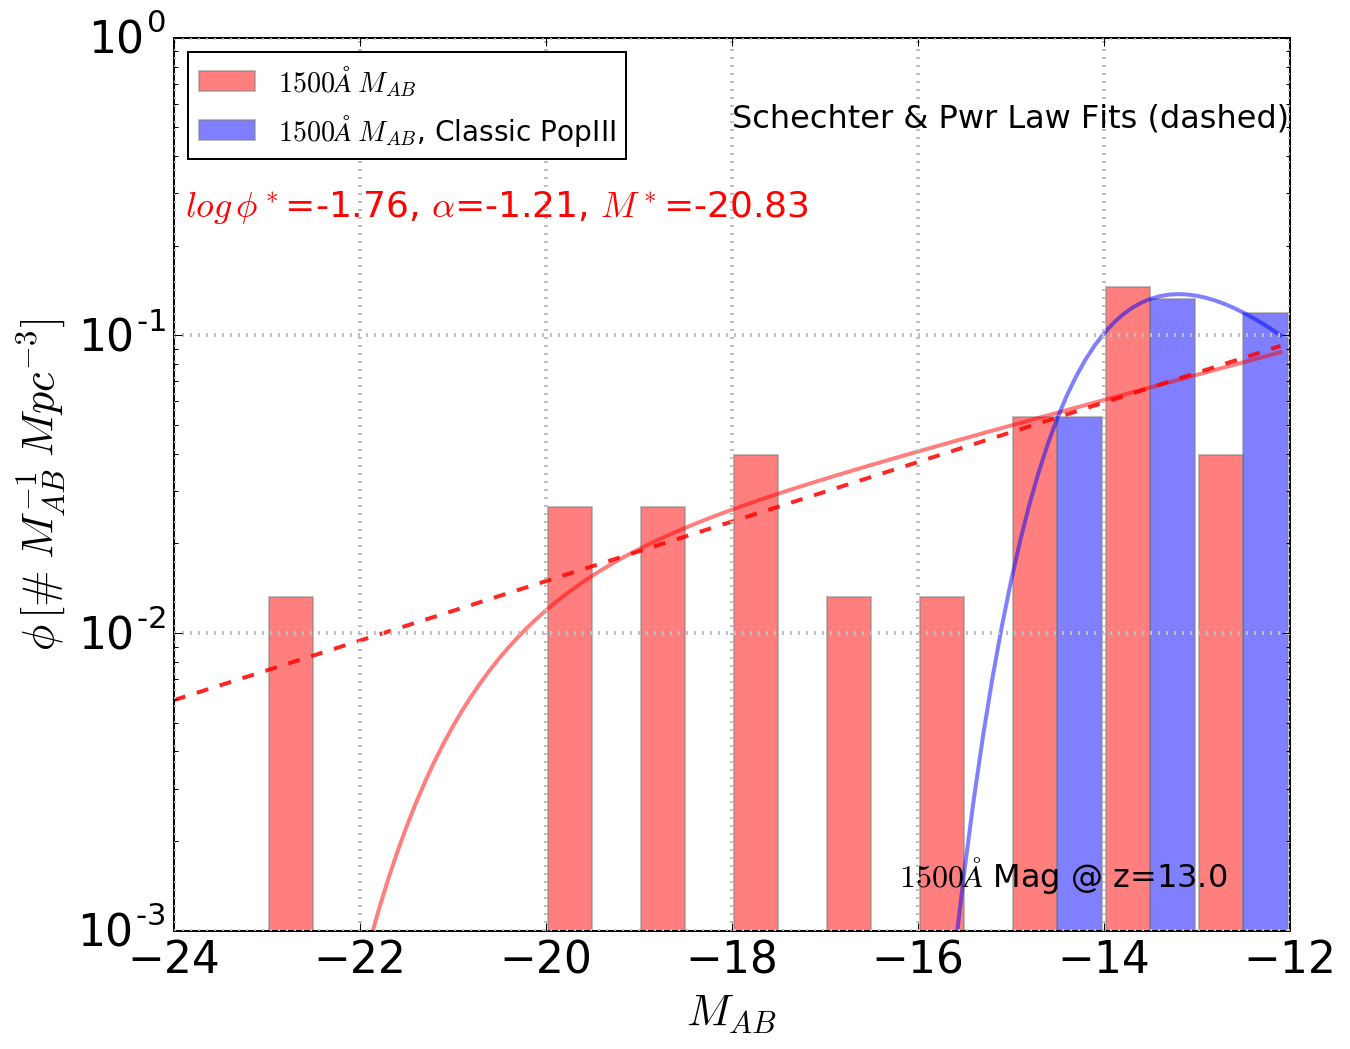

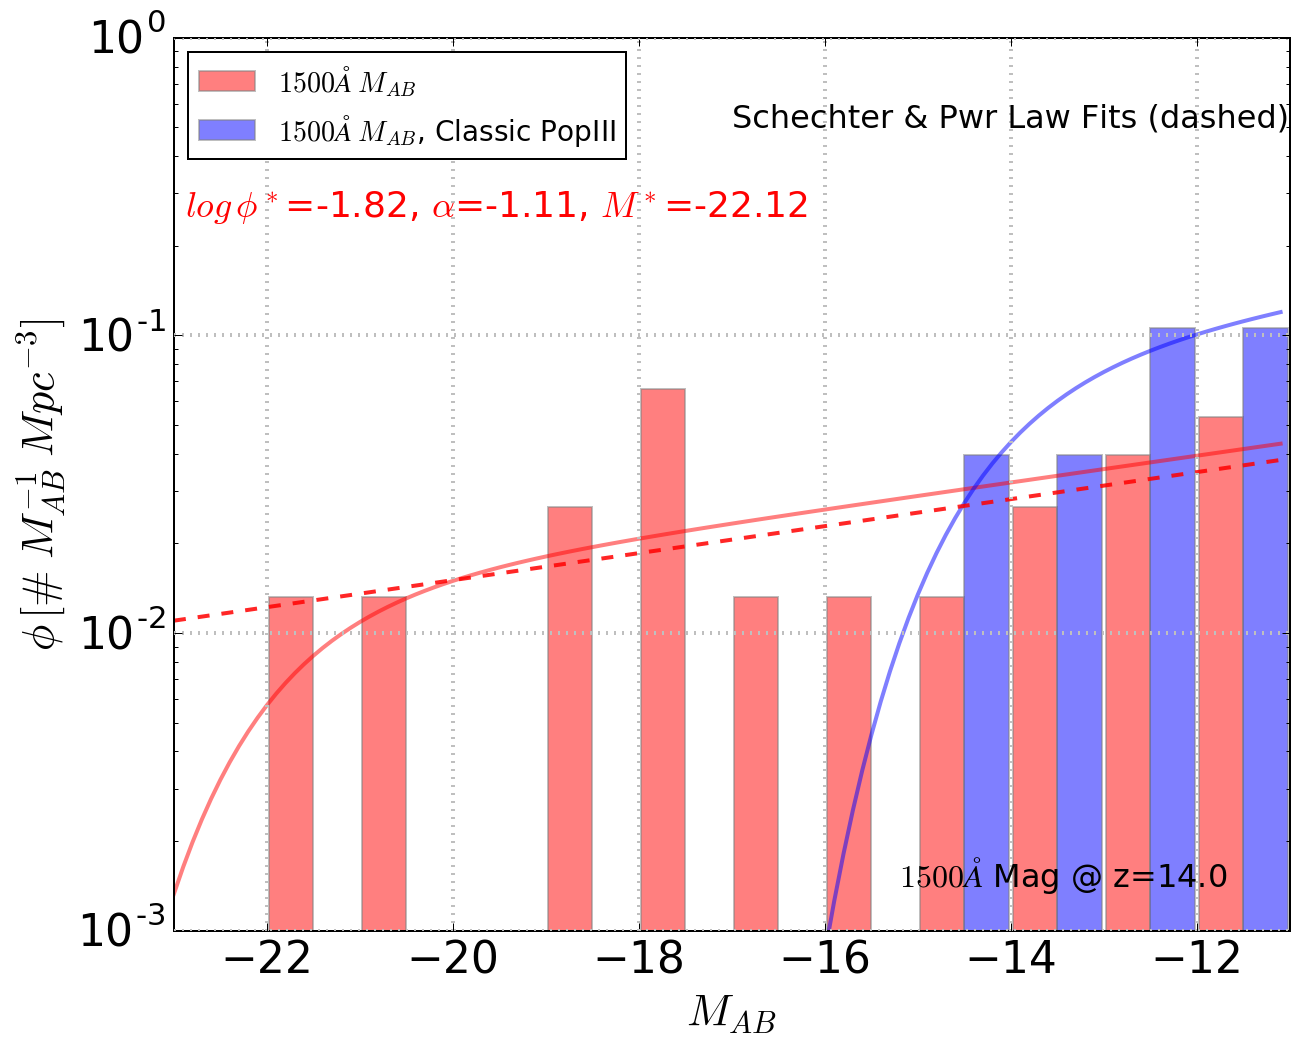

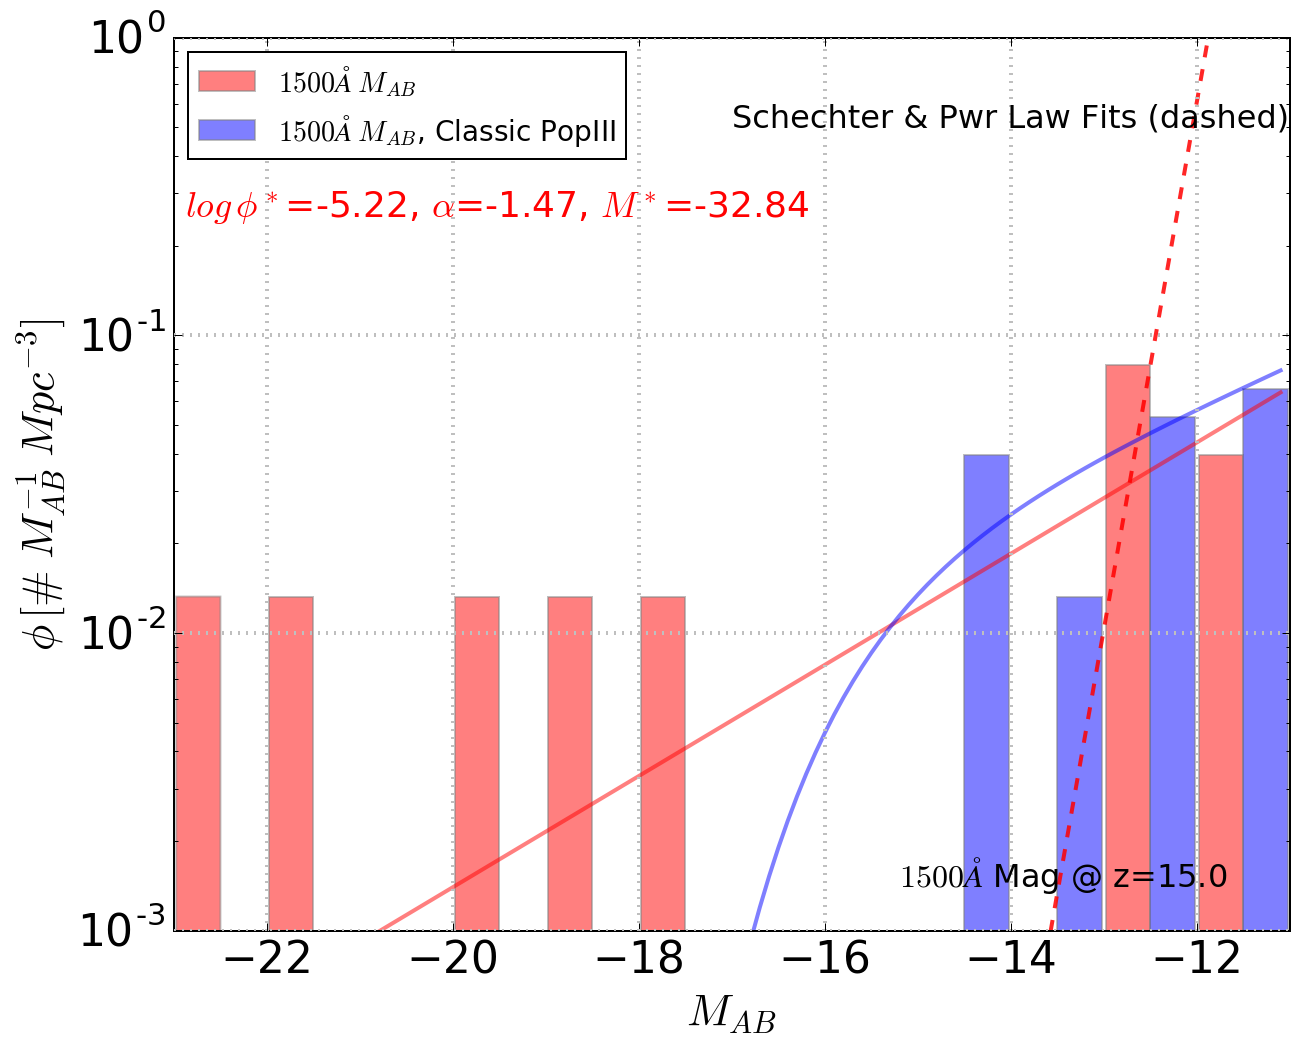

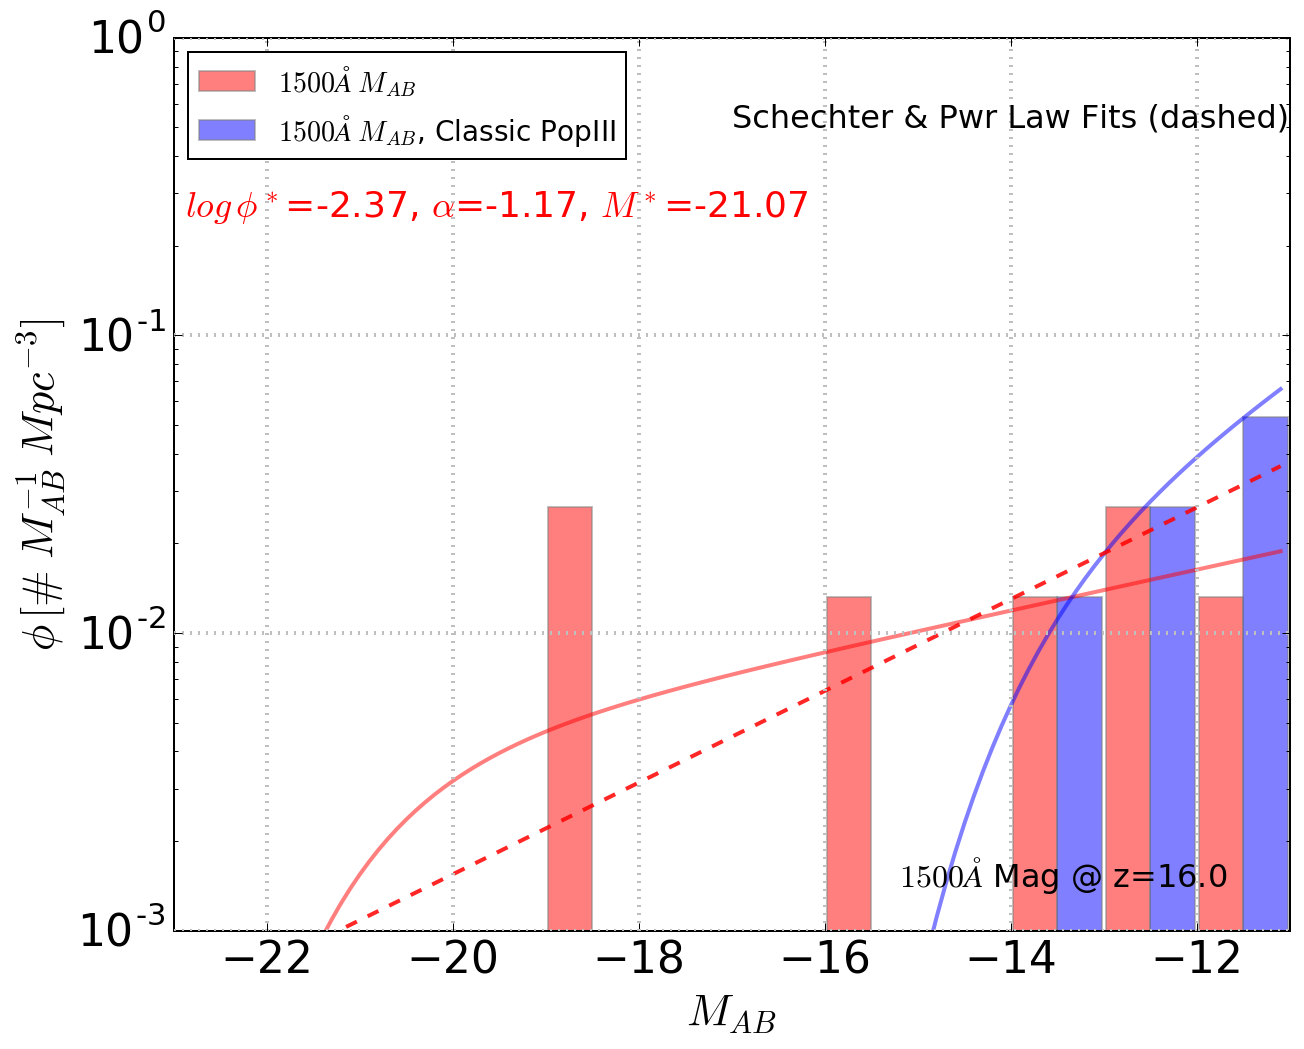

In [29]:
print("Limiting absolute magnitude: {:d}".format(limitM))
simVol = (3.0/0.71)**3

brightM = -24
limitM  = -12
pwrLawMinM = -12

rgForSFunc = np.arange(brightM,limitM, 0.1)

for z in np.sort(thezs):
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Convert observed magnitude to Absolute ...
    convertToM = -2.5*np.log10((cosmo.comoving_distance(z)/(10 * u.pc))**2 * (1+z))
    
    print("Convert to Abs Mag - factor = {:.2f}".format(convertToM))
    
    absMag, nmAbsMag = compMags(z)
    
    if z > 13:
        brightM = -23
        limitM  = -11

    magBins    = np.arange(brightM,limitM+1)
    rgForSFunc = np.arange(brightM,limitM, 0.1)

    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    n, bins, patches = ax.hist([absMag,nmAbsMag],bins=magBins,log=True, color='rb',
                               edgecolor=(0.5,0.5,0.5,0.5), alpha=0.5,rwidth = 0.95,
                               weights=[[1.0/simVol for i in absMag],
                                        [1.0/simVol for i in nmAbsMag]]) 

    ax.legend(['$1500\AA\;M_{AB}$','$1500\AA\;M_{AB}$, Classic PopIII'], 
              loc='upper left', fontsize=14 )
    # Plot Finkelstein
    if z in finkel.keys():
        ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k',lw=4,alpha=0.65)
        ax.annotate(r'$log\, \phi^*$={:.2f}, $\alpha$={:.2f}, $M^*$={:.2f}'.format(np.log10(finkel[z][0]),finkel[z][1],finkel[z][2]),
                    color='k',xycoords='axes fraction', textcoords='axes fraction', xy=(.5,.5), xytext=(.01,.75),size=18)


    # Find bin-centers
    binDelta = (bins[0]-bins[1])/2.0
    print(binDelta)
    binCenters = bins[1::]+binDelta
        
    ##### Find a Schechter fit for our galaxies ... #####    
    # The 'n[0]' array contains the values from the histogram for our computed M
    schecFitResults, success = optimize.leastsq(errfuncSchechter, p0[:], args=(binCenters[binCenters < limitM], n[0][binCenters < limitM]))
    if not success:
        print("UNABLE to fit to Schechter function at z={}".format(z))
    else:
        print(schecFitResults)
        ax.plot(rgForSFunc, schechterM_forFit(schecFitResults, rgForSFunc),'r',lw=2,alpha=0.5)
        ax.annotate(r'$log\, \phi^*$={:.2f}, $\alpha$={:.2f}, $M^*$={:.2f}'.format(np.log10(schecFitResults[0]),schecFitResults[1],schecFitResults[2]),color='r',
                    xycoords='axes fraction', textcoords='axes fraction', xy=(.5,.5), xytext=(.01,.8),size=18)

    ##### Find a Schechter fit for our galaxies ... #####    
    # The 'n[1]' array contains the values from the histogram for our computed M where Pop III requires Z_* < Z_crit
    schecFitResults, success = optimize.leastsq(errfuncSchechter, p0[:], args=(binCenters[binCenters < limitM], n[1][binCenters < limitM]))
    if not success:
        print("UNABLE to fit to Schechter function at z={}".format(z))
    else:
        ax.plot(rgForSFunc, schechterM_forFit(schecFitResults, rgForSFunc),'b',lw=2,alpha=0.5)

        
    pwrLawFitResults, success = optimize.leastsq(errfuncPwrLaw, p0[:], args=(binCenters[binCenters < pwrLawMinM], 
                                                                             n[0][binCenters < pwrLawMinM]))
    ax.plot(rgForSFunc, pwrLaw_forFit(pwrLawFitResults, rgForSFunc),'r--',lw=2,alpha=0.85)

    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_xlim([brightM,limitM])
    ax.set_ylim([1e-3,1])

    ax.annotate('$1500\AA$ Mag @ z={}'.format(z),xycoords='axes fraction',  xy=(.5,.5), 
                    textcoords='axes fraction', xytext=(.65,.05),size=16)
    ax.annotate('Schechter & Pwr Law Fits (dashed)',xycoords='axes fraction',  xy=(.5,.5), 
                    textcoords='axes fraction', xytext=(.5,.90),size=16)
    ax.set_xlabel('$M_{AB}$')
    ax.set_ylabel(r'$\phi\, [\#\; M_{AB}^{-1}\; Mpc^{-3}]$')
    ax.grid(color='0.75', linestyle=':', linewidth=2)

#     plt.gca().invert_xaxis()
    plt.savefig("haloZVsUVMag_{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    gc.collect()
gc.collect()

In [30]:
magBins=np.arange(-24,-9)
absMag, nmAbsMag = compMags(14)

# a, bins=10, range=None, density=False, weights=None, density=None
nTemp, bins = np.histogram(absMag,bins=magBins, density=False,
                                weights=[1.0/simVol for i in absMag]) 


Convert to Abs Mag - DM = -48.04 @ z=14.0


Lets look at a scatter plot of the histogram of halo UV luminosities similar to what O'Shea has done 
with the Reinassance simulations


In [31]:
nTempA,nTempA[AllNonZero],binCentersA,binCentersA[AllNonZero]

NameError: name 'nTempA' is not defined

In [32]:
fluxes[]

SyntaxError: invalid syntax (<ipython-input-32-af5f21e623c1>, line 1)

Limiting absolute magnitude: -2
Convert to Abs Mag - factor = -46.76
Convert to Abs Mag - DM = -46.76 @ z=6.0
Convert to Abs Mag - factor = -47.00
Convert to Abs Mag - DM = -47.00 @ z=7.0
Convert to Abs Mag - factor = -47.21
Convert to Abs Mag - DM = -47.21 @ z=8.0
Convert to Abs Mag - factor = -47.39
Convert to Abs Mag - DM = -47.39 @ z=9.0
Convert to Abs Mag - factor = -47.55
Convert to Abs Mag - DM = -47.55 @ z=10.0
Convert to Abs Mag - factor = -47.69
Convert to Abs Mag - DM = -47.69 @ z=11.0
Convert to Abs Mag - factor = -47.82
Convert to Abs Mag - DM = -47.82 @ z=12.0
Convert to Abs Mag - factor = -47.94
Convert to Abs Mag - DM = -47.94 @ z=13.0
Convert to Abs Mag - factor = -48.04
Convert to Abs Mag - DM = -48.04 @ z=14.0
Convert to Abs Mag - factor = -48.14
Convert to Abs Mag - DM = -48.14 @ z=15.0


0

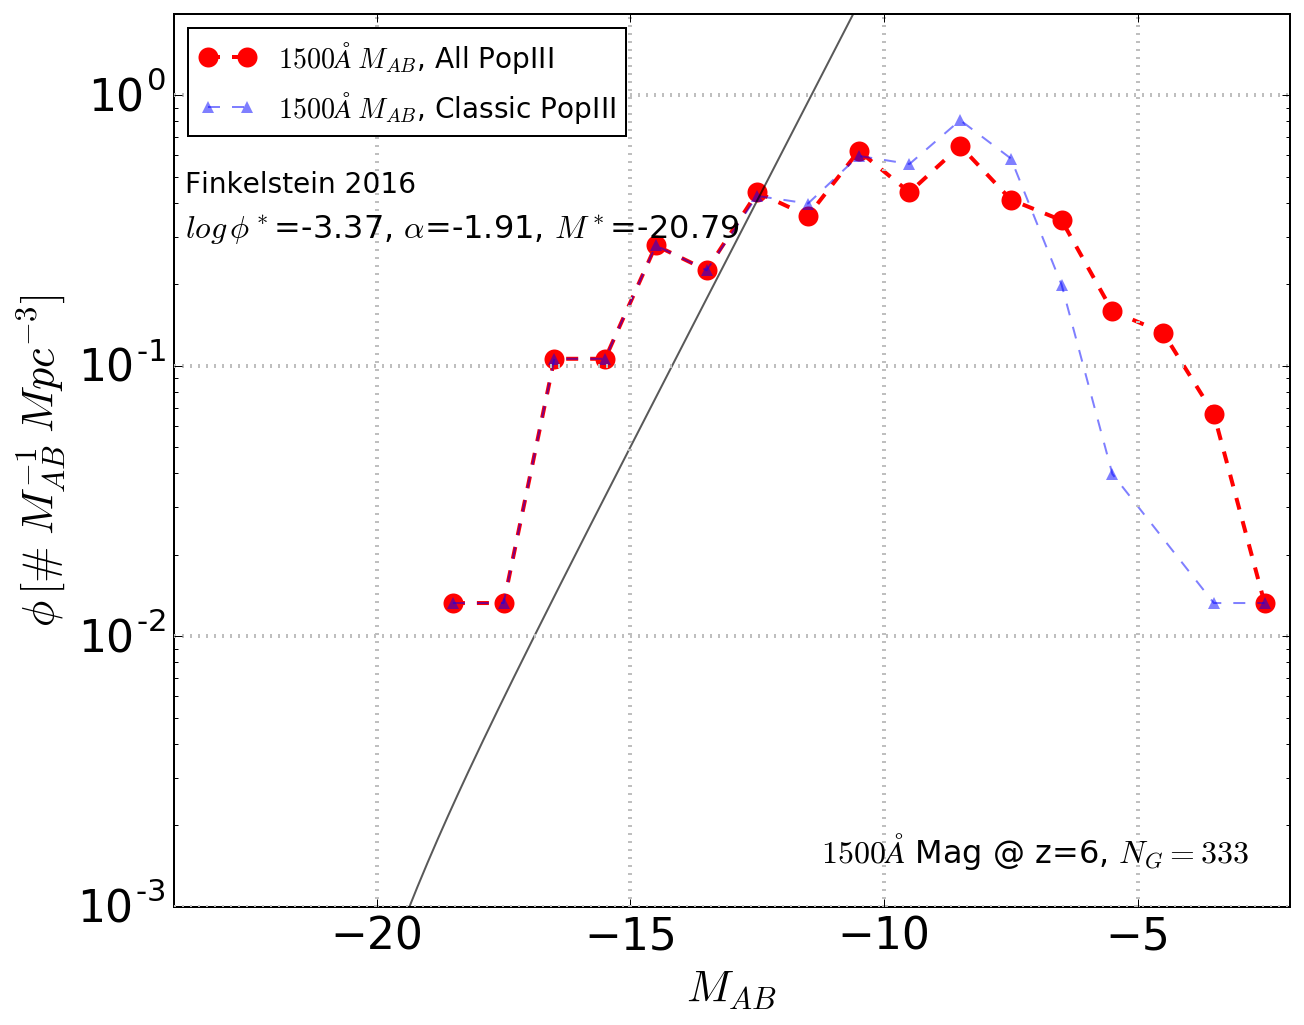

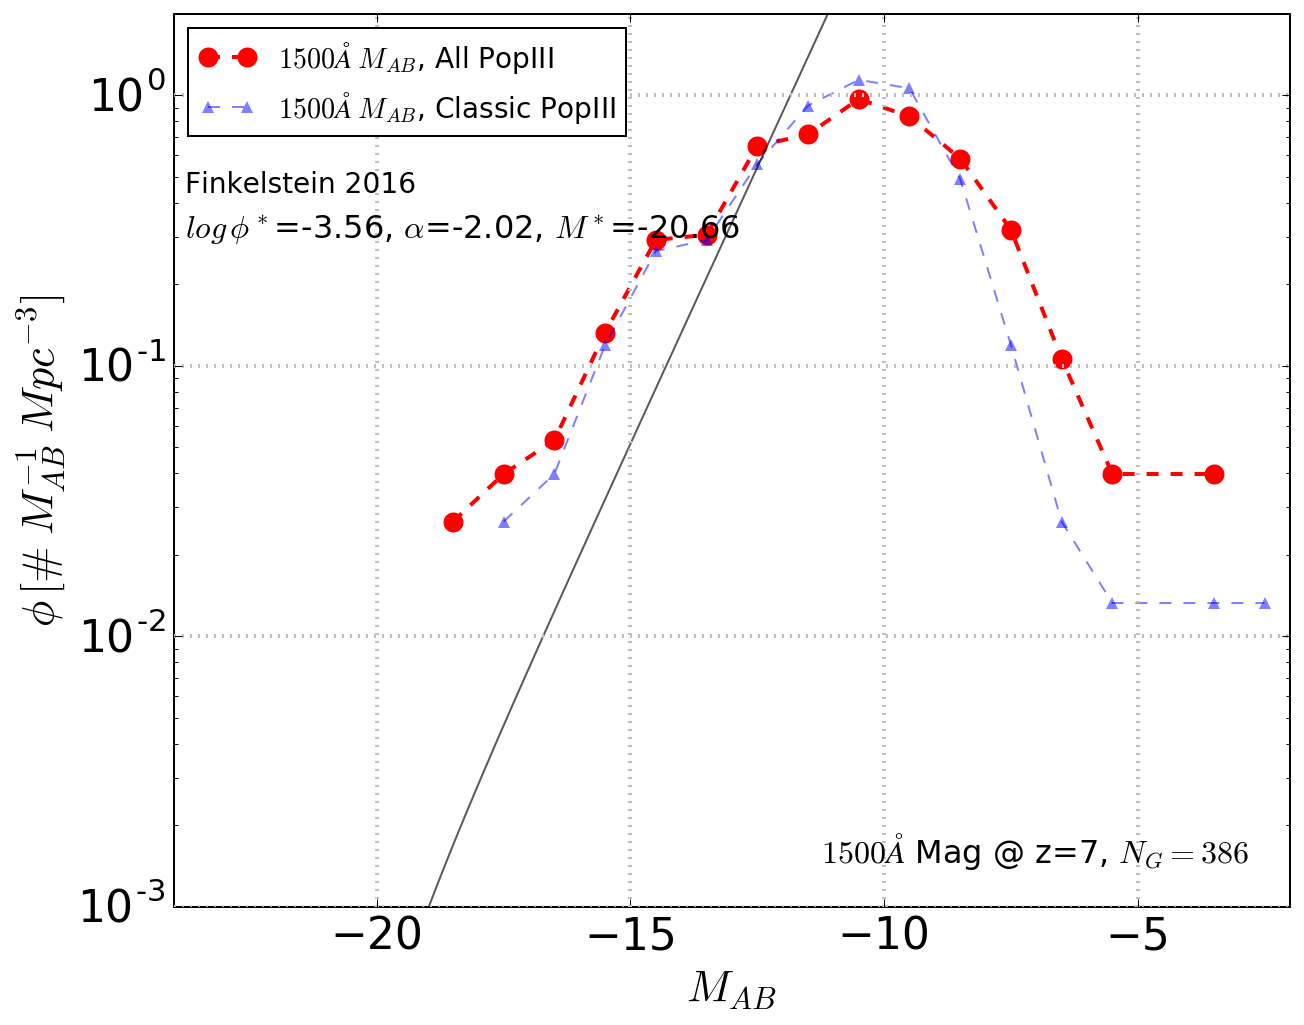

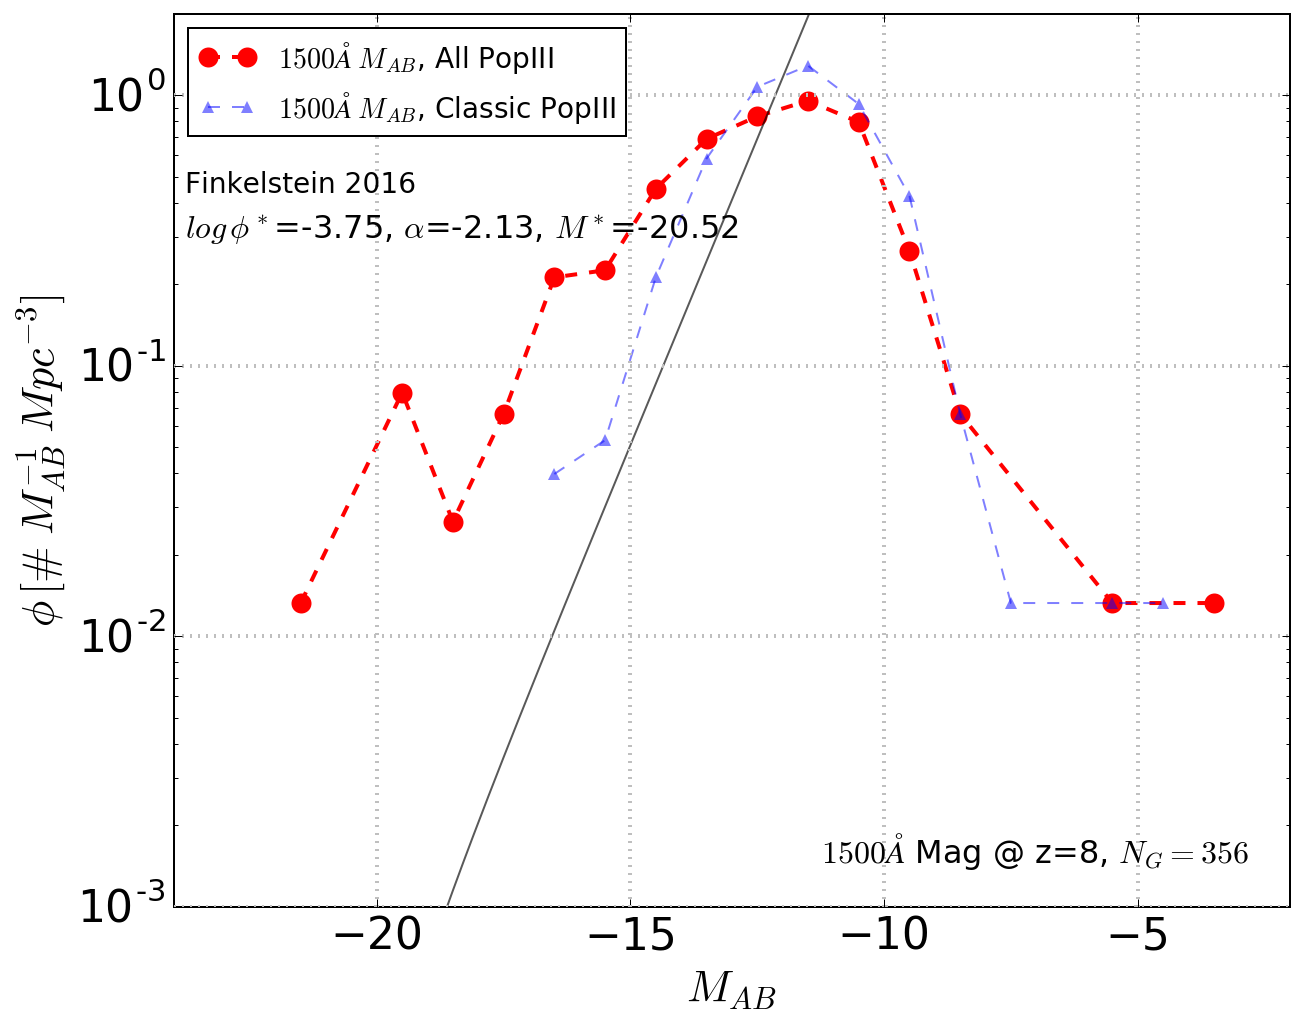

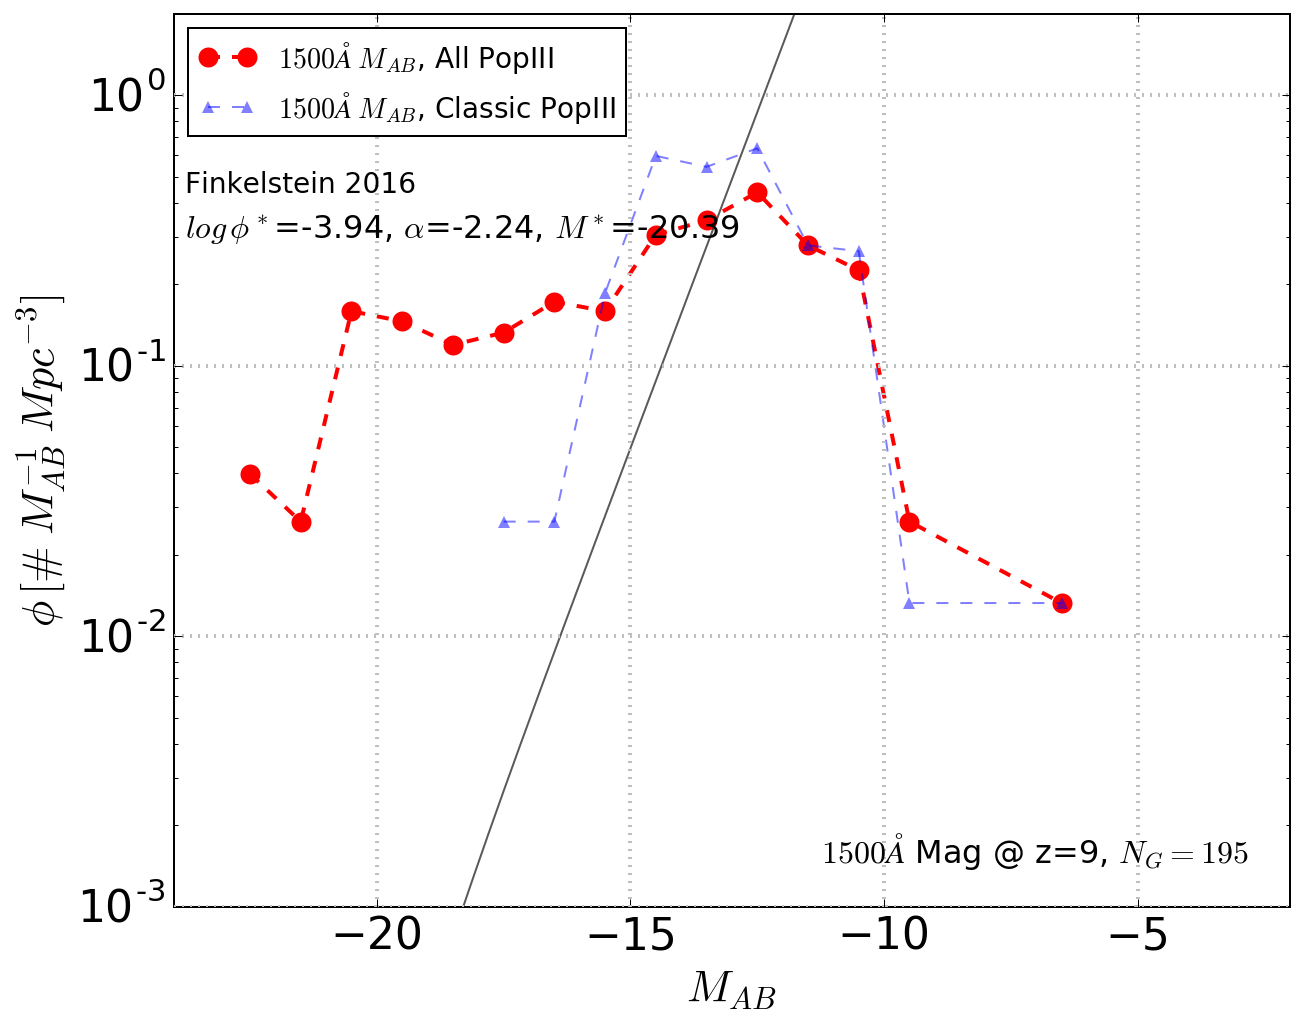

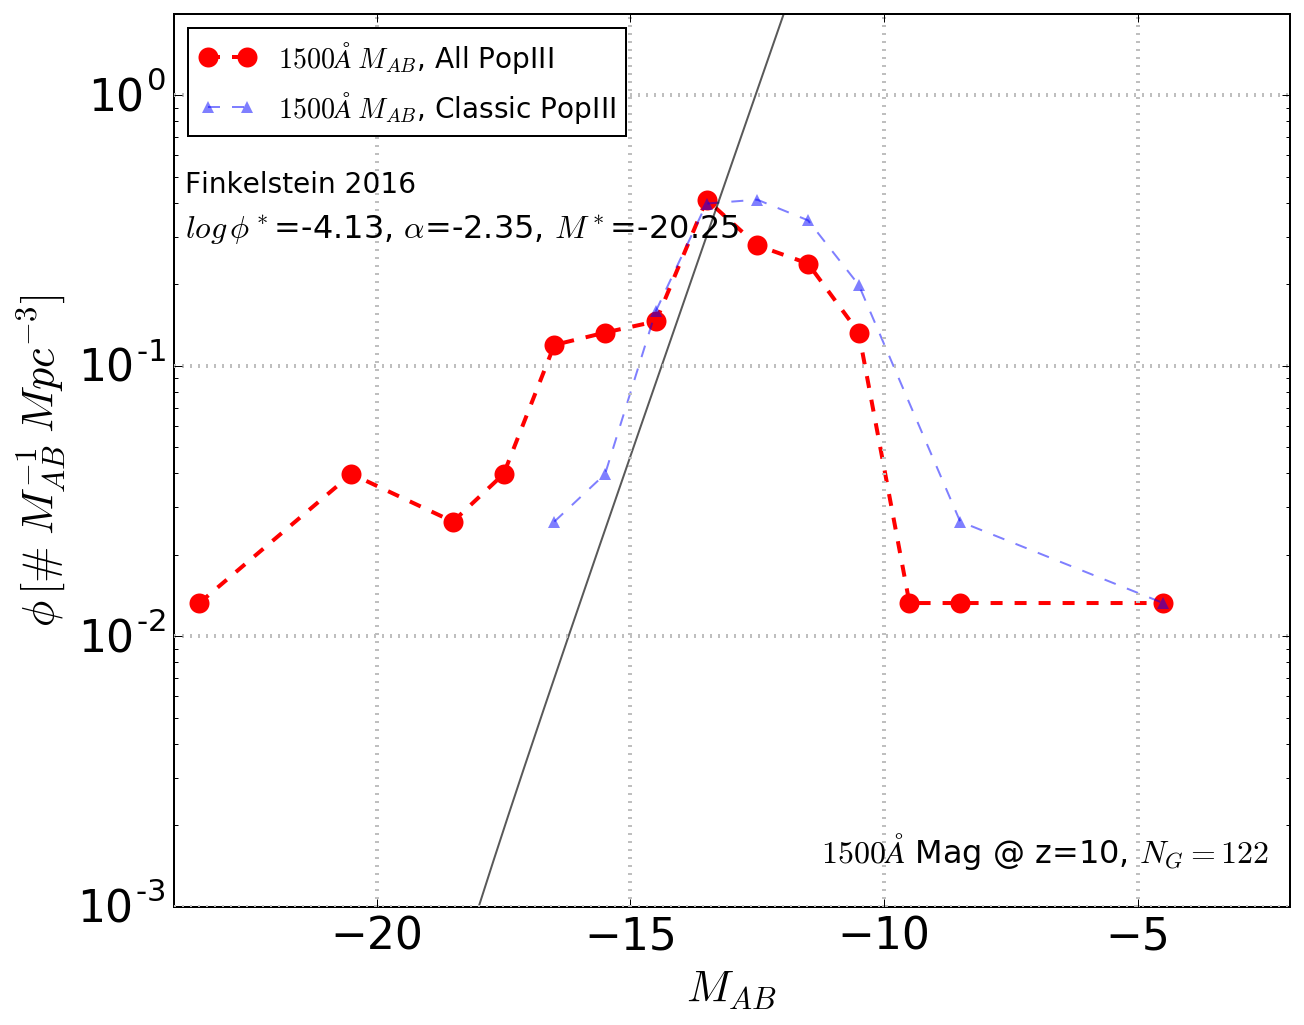

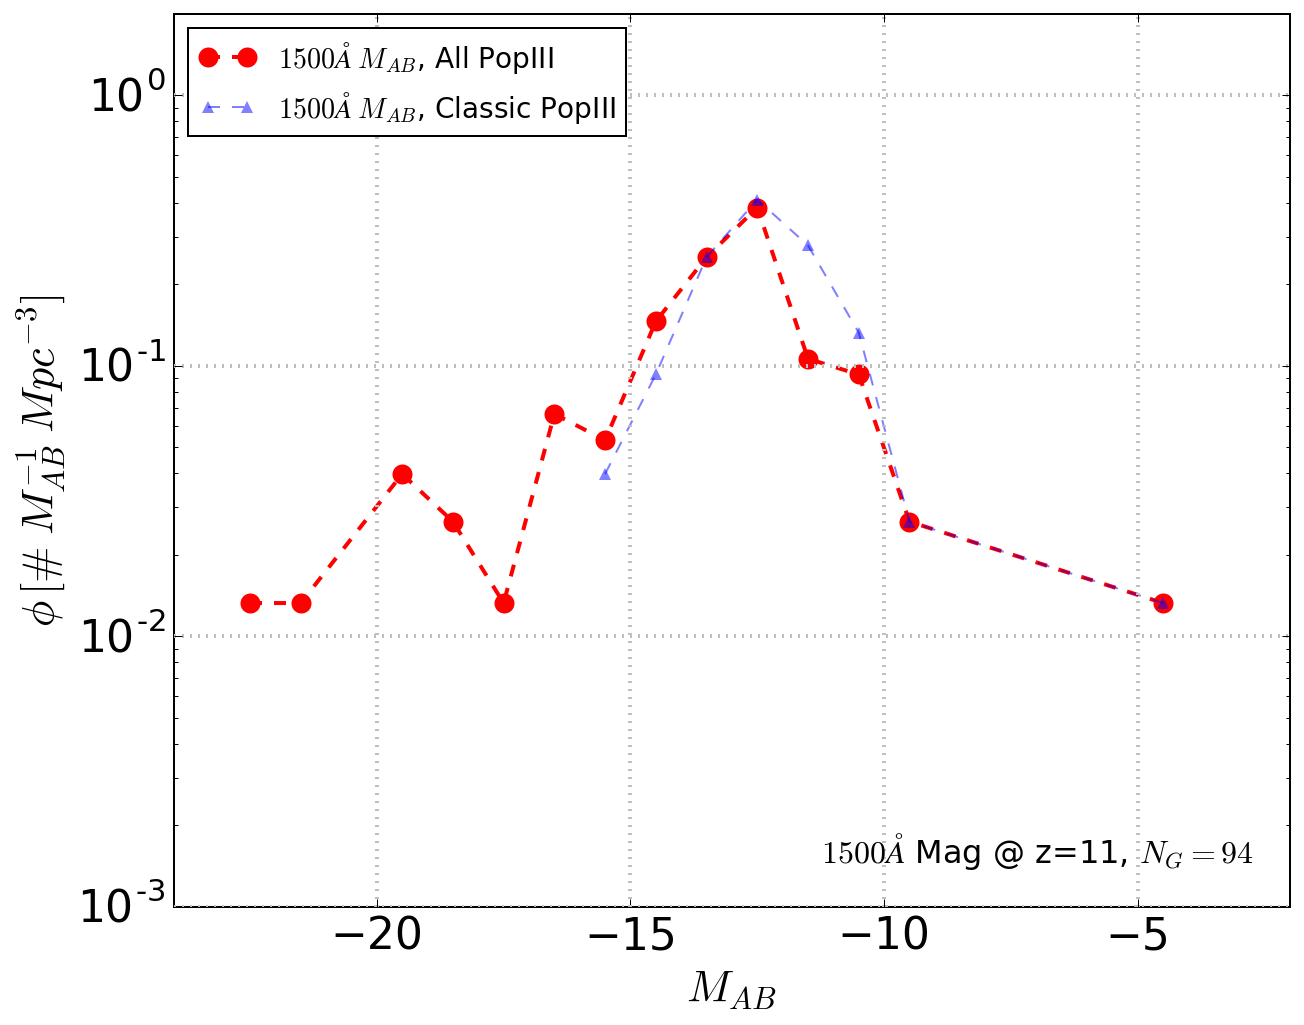

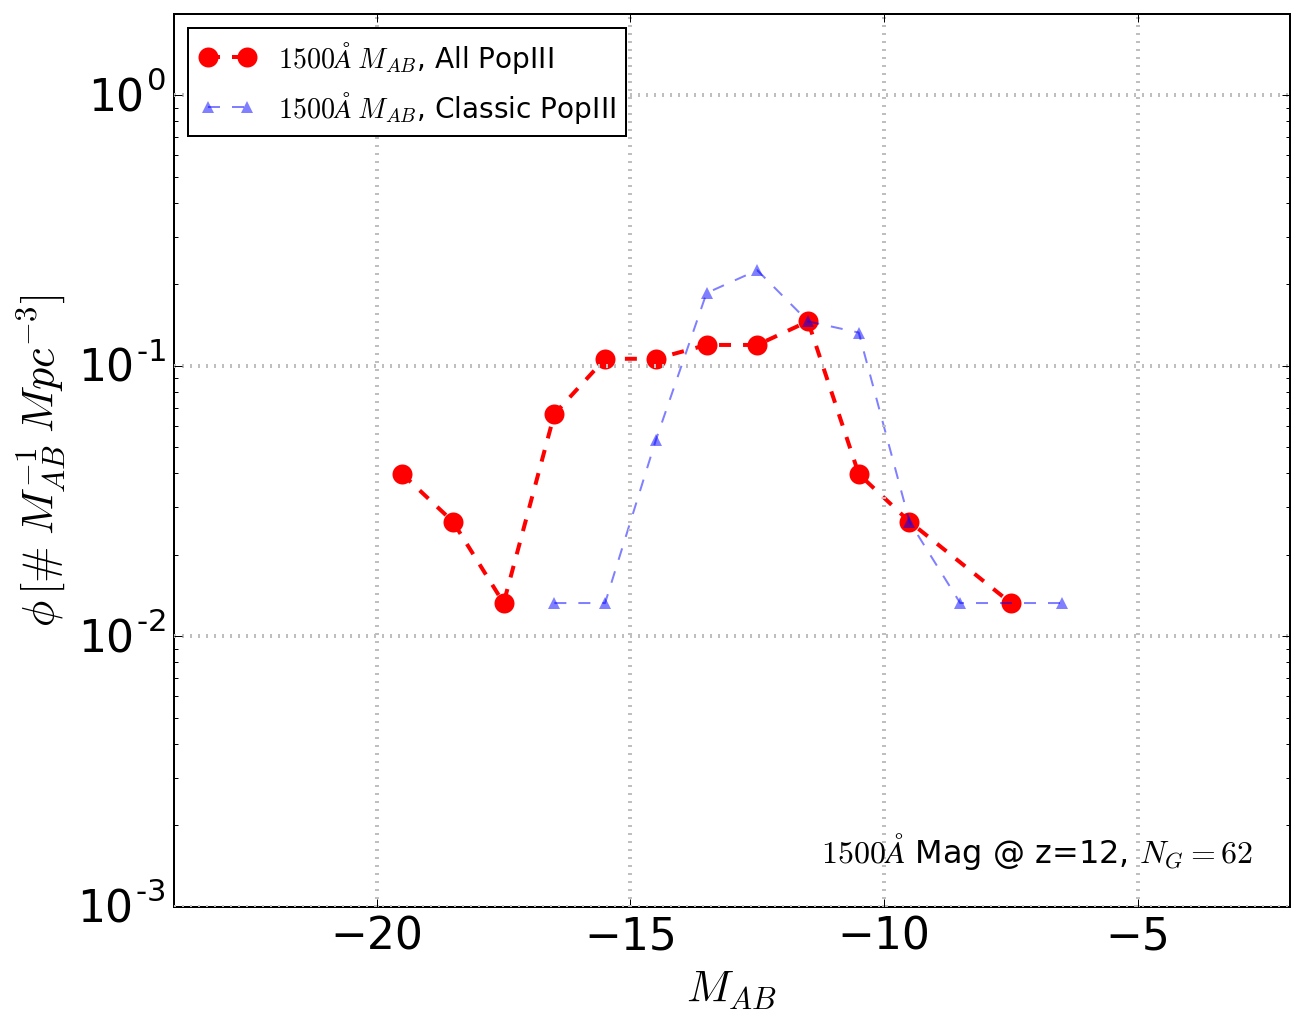

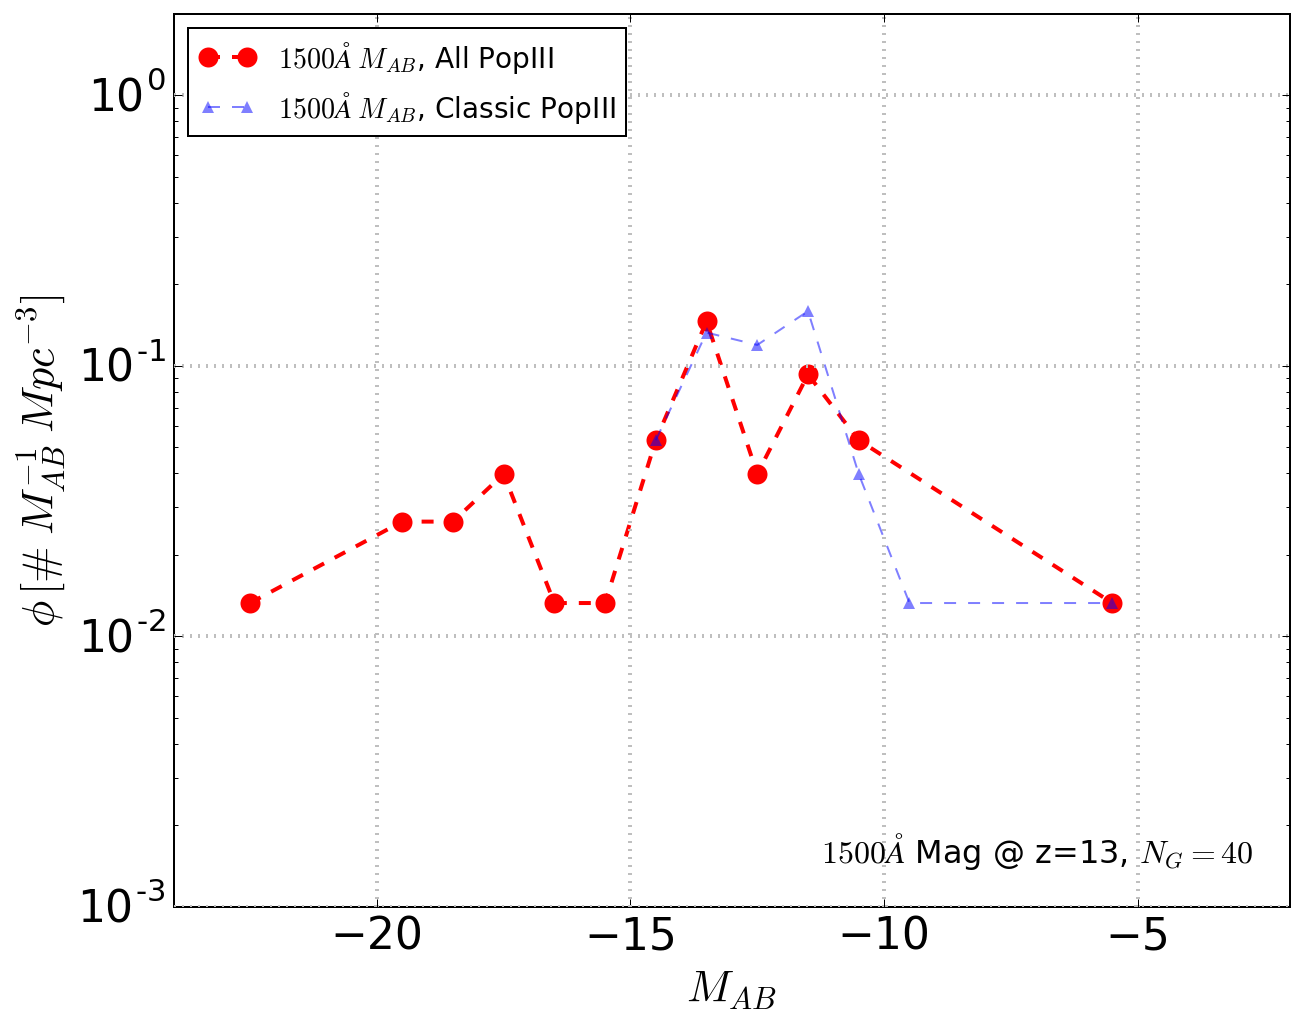

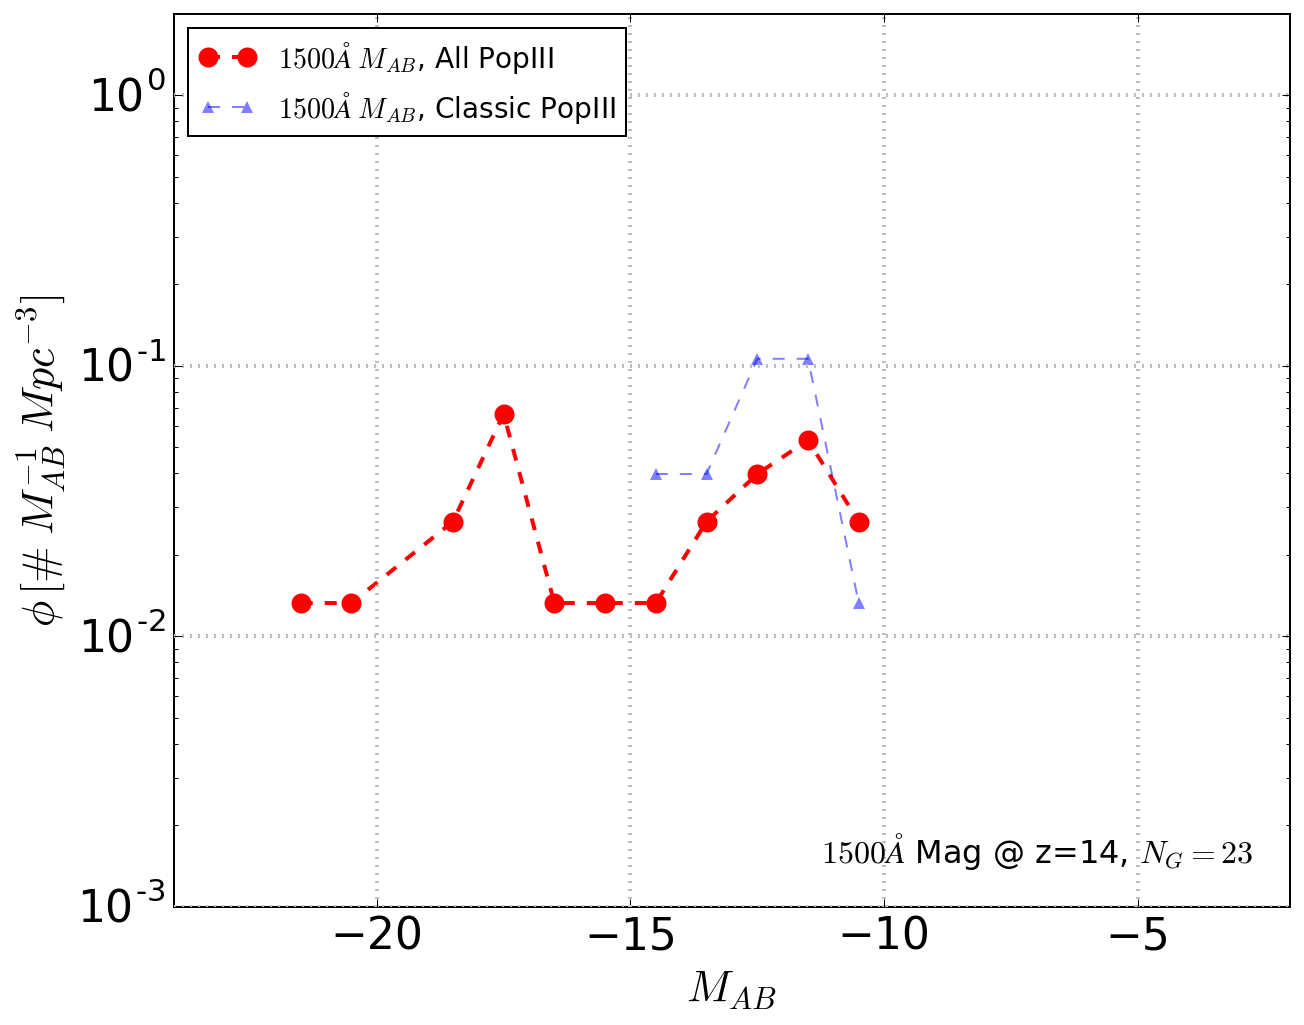

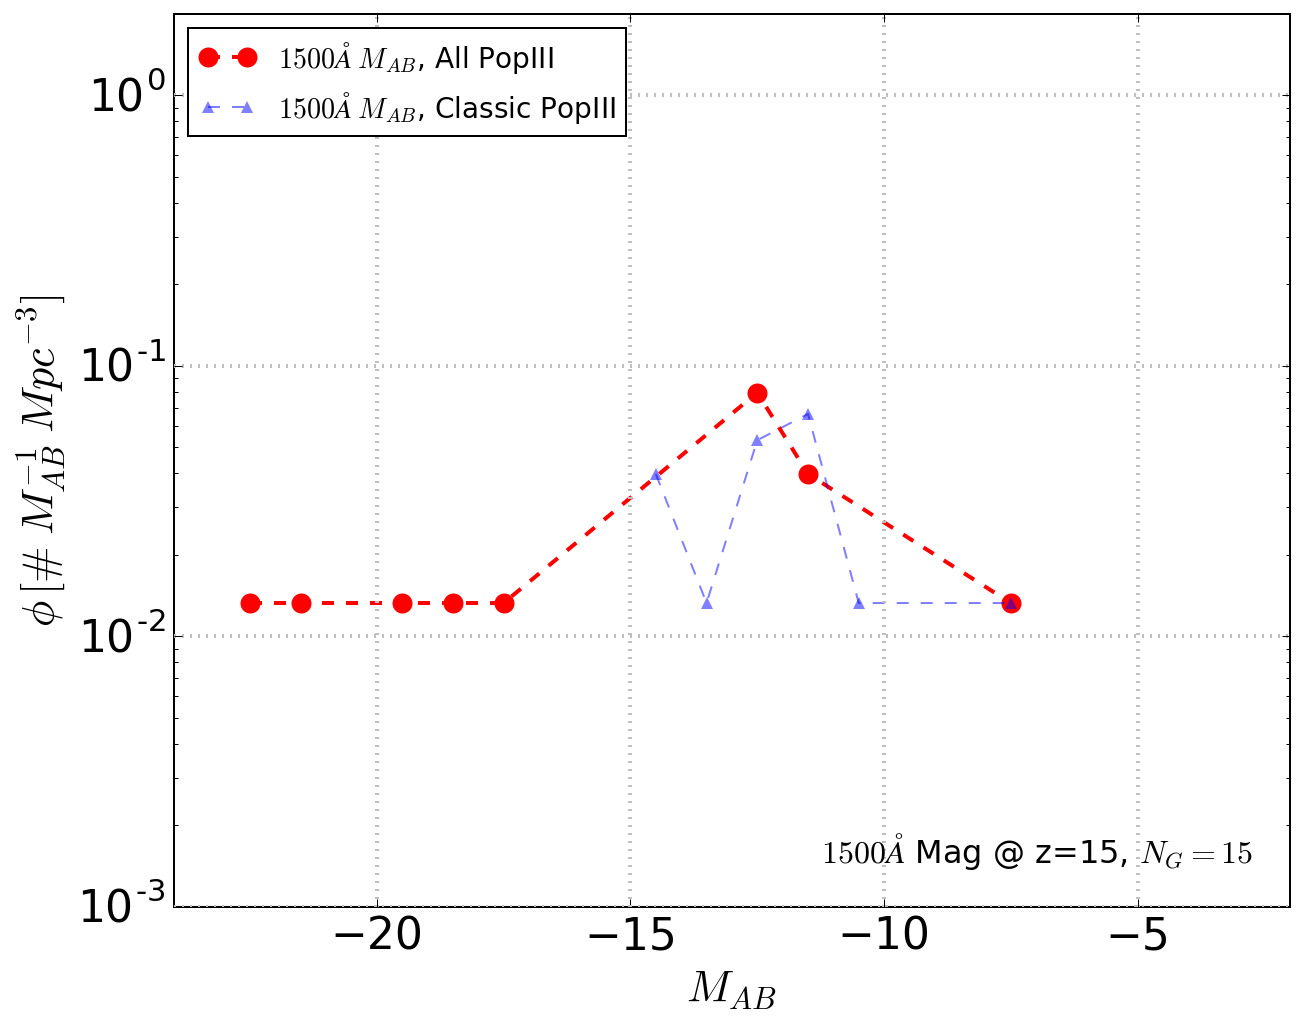

In [34]:
brightM = -24
limitM  = -2
pwrLawMinM = -2

print("Limiting absolute magnitude: {:d}".format(limitM))
simVol = (3.0/0.71)**3

rgForSFunc = np.arange(-26,limitM, 0.1)

#for z in np.sort(thezs):
for z in np.sort([6,7,8,9,10,11,12,13,14,15]):
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Convert observed magnitude to Absolute ...
    convertToM = -2.5*np.log10((cosmo.comoving_distance(z)/(10 * u.pc))**2 * (1+z))
    
    print("Convert to Abs Mag - factor = {:.2f}".format(convertToM))
    
    absMag, nmAbsMag = compMags(z)
    Ng = len(absMag)

    magBins = np.linspace(brightM,limitM,-brightM+limitM+1) 
    
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    nTempA, binsA = np.histogram(absMag,bins=magBins, density=False,
                                weights=[1.0/simVol for i in absMag]) 
    nTempN, binsN = np.histogram(nmAbsMag,bins=magBins, density=False,
                                weights=[1.0/simVol for i in absMag]) 
    ################################
    # Replace zero halos in a bin with
    # nan ... since we are undersampled
    ################################
    AllNonZero   = np.nonzero(nTempA) # Define a mask of non-zero values
    ClassNonZero = np.nonzero(nTempN)
    
    # Find bin-centers
    binDeltaA = (binsA[0]-binsA[1])/2.0
#     print(binDeltaA)
    binCentersA = binsA[1::]+binDeltaA
    
    binDeltaN = (binsN[0]-binsN[1])/2.0
#     print(binDeltaN)
    binCentersN = binsN[1::]+binDeltaN

    # So here we are only plotting non-zero values -- and connecting them with a line.
    # So there are dropouts in this data that we are ignorning! I think this is ok since
    # we are sampling a small volume and are gonna miss halos in the intermediate mags
    ax.plot(binCentersA[AllNonZero],nTempA[AllNonZero],'ro--',markersize=10,lw=2,mec='None')
    ax.plot(binCentersN[ClassNonZero],nTempN[ClassNonZero],'b^--',markersize=6,lw=1,mec='None',alpha=0.5)
    
    ax.legend(['$1500\AA\;M_{AB}$, All PopIII','$1500\AA\;M_{AB}$, Classic PopIII'], 
              loc='upper left', fontsize=14 )
    # Plot Finkelstein
    if z in finkel.keys():
        ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k',lw=1,alpha=0.65)
        ax.annotate(r'Finkelstein 2016',xycoords='axes fraction',  xy=(.5,.5), 
                    textcoords='axes fraction', xytext=(.01,.80),size=14)
        ax.annotate(r'$log\, \phi^*$={:.2f}, $\alpha$={:.2f}, $M^*$={:.2f}'.format(np.log10(finkel[z][0]),finkel[z][1],finkel[z][2]),
                    color='k',xycoords='axes fraction', textcoords='axes fraction', xy=(.5,.5), xytext=(.01,.75),size=16)


    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_xlim([brightM,limitM])
    ax.set_ylim([1e-3,2])

    ax.annotate('$1500\AA$ Mag @ z={}, $N_G={}$'.format(z,Ng),xycoords='axes fraction',  xy=(.5,.5), 
                    textcoords='axes fraction', xytext=(.58,.05),size=16)
    ax.set_xlabel('$M_{AB}$')
    ax.set_ylabel(r'$\phi\, [\#\; M_{AB}^{-1}\; Mpc^{-3}]$')
    ax.grid(color='0.75', linestyle=':', linewidth=2)

#     plt.gca().invert_xaxis()
    plt.savefig("haloUVMag_{:.1f}_scatter.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    gc.collect()
gc.collect()

Limiting absolute magnitude: -5


NameError: name 'cosmo' is not defined

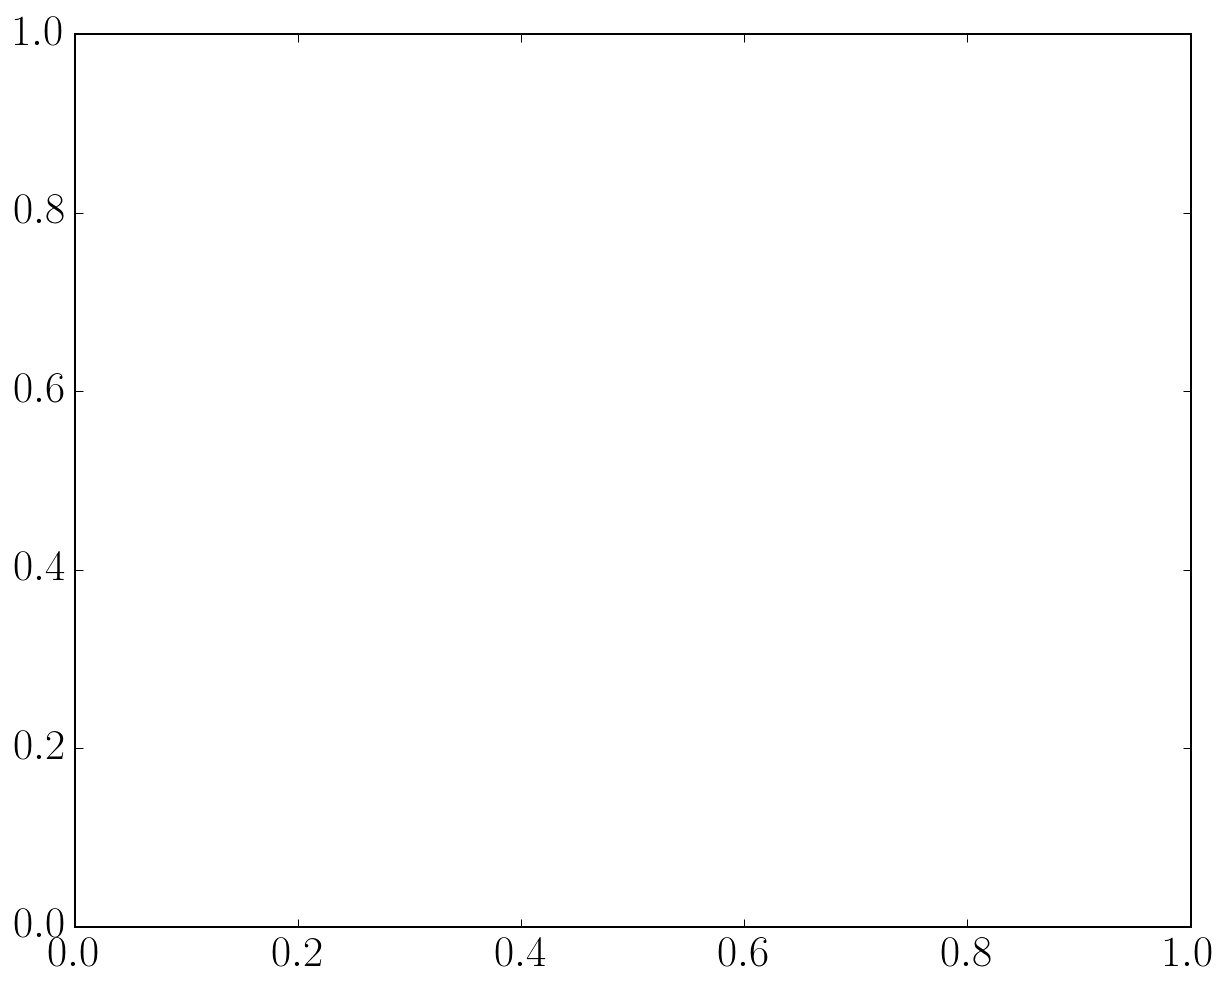

In [218]:
brightM = -24
limitM  = -5
pwrLawMinM = -2

print("Limiting absolute magnitude: {:d}".format(limitM))
simVol = (3.0/0.71)**3

rgForSFunc = np.arange(-26,limitM, 0.1)

#for z in np.sort(thezs):
for z in np.sort([5,6,8,9,10,11,12,15]):
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Convert observed magnitude to Absolute ...
    convertToM = -2.5*np.log10((cosmo.comoving_distance(z)/(10 * u.pc))**2 * (1+z))
    
    print("Convert to Abs Mag - factor = {:.2f}".format(convertToM))
    
    absMag, nmAbsMag = compMags(z)
    Ng = len(absMag)
    magBins = np.linspace(brightM,limitM,-brightM+limitM+1) 
    
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    nTempA, binsA = np.histogram(absMag,bins=magBins, density=False,
                                weights=[1.0/simVol for i in absMag]) 
    nTempN, binsN = np.histogram(nmAbsMag,bins=magBins, density=False,
                                weights=[1.0/simVol for i in absMag]) 
    ################################
    # Replace zero halos in a bin with
    # nan ... since we are undersampled
    ################################
    AllNonZero   = np.nonzero(nTempA) # Define a mask of non-zero values
    ClassNonZero = np.nonzero(nTempN)
    
    # Find bin-centers
    binDeltaA = (binsA[0]-binsA[1])/2.0
#     print(binDeltaA)
    binCentersA = binsA[1::]+binDeltaA
    
    binDeltaN = (binsN[0]-binsN[1])/2.0
#     print(binDeltaN)
    binCentersN = binsN[1::]+binDeltaN

    # So here we are only plotting non-zero values -- and connecting them with a line.
    # So there are dropouts in this data that we are ignorning! I think this is ok since
    # we are sampling a small volume and are gonna miss halos in the intermediate mags
    ax.plot(binCentersA[AllNonZero],nTempA[AllNonZero],'ro--',markersize=10,lw=2,mec='None')
    ax.plot(binCentersN[ClassNonZero],nTempN[ClassNonZero],'b^--',markersize=6,lw=1,mec='None',alpha=0.5)
    
    ax.legend(['$1500\AA\;M_{AB}$, All PopIII','$1500\AA\;M_{AB}$, Classic PopIII'], 
              loc='upper left', fontsize=14 )
    # Plot Finkelstein
    if z in finkel.keys():
        ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k',lw=1,alpha=0.65)
        ax.annotate(r'Finkelstein 2016',xycoords='axes fraction',  xy=(.5,.5), 
                    textcoords='axes fraction', xytext=(.01,.80),size=14)
        ax.annotate(r'$log\, \phi^*$={:.2f}, $\alpha$={:.2f},'+"\n"+ r'$M^*$={:.2f}'.format(np.log10(finkel[z][0]),finkel[z][1],finkel[z][2]),
                    color='k',xycoords='axes fraction', textcoords='axes fraction', xy=(.5,.5), xytext=(.01,.75),size=16)


    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_xlim([brightM,limitM])
    ax.set_ylim([1e-3,1])

    ax.annotate('$1500\AA$ Mag @ z={}, $N_G={}$'.format(z,Ng),xycoords='axes fraction',  xy=(.5,.5), 
                    textcoords='axes fraction', xytext=(.58,.05),size=16)
    ax.set_xlabel('$M_{AB}$')
    ax.set_ylabel(r'$\phi\, [\#\; M_{AB}^{-1}\; Mpc^{-3}]$')
    ax.grid(color='0.75', linestyle=':', linewidth=2)

#     plt.gca().invert_xaxis()
    plt.savefig("haloZVsUVMag_{:.1f}_scatter.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    gc.collect()
gc.collect()

# Load the DM-based Halo's ... Computer their DM mass for the paper

In [35]:
Odm = 0.222 # Om - Ob = Odm
h0  = 0.71
dmPartMass = 5.58e4 * Odm / h0 * u.Msun

In [36]:
# loadHaloSize returns and array of pairs: (indx, # of DM particles)
halosizes = {z: lsp.loadHaloSizes(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/27Aug15-3Mpc-output/hop/') 
     for z,num in zip([15,14,13,12,11,10,9,8,7,6,5],[20,26,33,43,58,73,97,121,152,191,241])}

In [37]:
# Create a list of masses {z: (mass0, mass1, ..., massn)} for all the halos at redshift z
# Units are solar masses
halomasses = {z: [[n*dmPartMass.value] for i,n in halosizes[z]] for z in [15,14,13,12,11,10,9,8,7,6,5]}

In [45]:
halosizes[5][15][1]*dmPartMass,halomasses[5][15]

(<Quantity 3441816147.042254 solMass>, [3441816147.042254])

In [56]:
# from collections import OrderedDict
labels = ['z={}'.format(z) for z in [15,14,13,12,11,10,9,8,7,6,5]]

In [57]:
labels

['z=15',
 'z=14',
 'z=13',
 'z=12',
 'z=11',
 'z=10',
 'z=9',
 'z=8',
 'z=7',
 'z=6',
 'z=5']

In [50]:
pd.options.display.float_format = '{:,.2e} $M_\odot$'.format
columns = {z: pd.DataFrame(halomasses[z]) for z in [15,14,13,12,11,10,9,8,7,6,5]}

In [51]:
table = pd.concat([columns[z] for z in [15,14,13,12,11,10,9,8,7,6,5] ],ignore_index=True, axis=1)

In [58]:
table.columns=labels

In [59]:
table.head(15) #### This is backwards ... 

z=15               z=14               z=13  \
0  2.07e+08 $M_\odot$ 3.06e+08 $M_\odot$ 3.57e+08 $M_\odot$   
1  9.53e+07 $M_\odot$ 2.83e+08 $M_\odot$ 3.28e+08 $M_\odot$   
2  9.03e+07 $M_\odot$ 1.21e+08 $M_\odot$ 2.26e+08 $M_\odot$   
3  7.72e+07 $M_\odot$ 1.13e+08 $M_\odot$ 2.26e+08 $M_\odot$   
4  7.52e+07 $M_\odot$ 1.05e+08 $M_\odot$ 1.97e+08 $M_\odot$   
5  7.21e+07 $M_\odot$ 9.28e+07 $M_\odot$ 1.52e+08 $M_\odot$   
6  7.12e+07 $M_\odot$ 8.89e+07 $M_\odot$ 1.36e+08 $M_\odot$   
7  5.99e+07 $M_\odot$ 8.65e+07 $M_\odot$ 1.27e+08 $M_\odot$   
8  5.96e+07 $M_\odot$ 8.31e+07 $M_\odot$ 1.25e+08 $M_\odot$   
9  5.88e+07 $M_\odot$ 7.51e+07 $M_\odot$ 1.23e+08 $M_\odot$   
10 5.75e+07 $M_\odot$ 7.43e+07 $M_\odot$ 1.21e+08 $M_\odot$   
11 5.46e+07 $M_\odot$ 7.42e+07 $M_\odot$ 1.11e+08 $M_\odot$   
12 5.27e+07 $M_\odot$ 7.39e+07 $M_\odot$ 1.04e+08 $M_\odot$   
13 5.20e+07 $M_\odot$ 7.04e+07 $M_\odot$ 9.74e+07 $M_\odot$   
14 5.16e+07 $M_\odot$ 6.82e+07 $M_\odot$ 8.95e+07 $M_\odot$   

                 z=12               z=11               z=10  \
0  6.62e+08 $M_\odot$ 8.76e+08 $M_\odot$ 1.46e+09 $M_\odot$   
1  6.47e+08 $M_\odot$ 8.09e+08 $M_\odot$ 1.20e+09 $M_\odot$   
2  4.17e+08 $M_\odot$ 7.22e+08 $M_\odot$ 1.19e+09 $M_\odot$   
3  3.74e+08 $M_\odot$ 7.17e+08 $M_\odot$ 9.61e+08 $M_\odot$   
4  3.59e+08 $M_\odot$ 4.94e+08 $M_\odot$ 7.26e+08 $M_\odot$   
5  2.37e+08 $M_\odot$ 3.72e+08 $M_\odot$ 5.18e+08 $M_\odot$   
6  2.11e+08 $M_\odot$ 3.38e+08 $M_\odot$ 4.43e+08 $M_\odot$   
7  1.79e+08 $M_\odot$ 3.03e+08 $M_\odot$ 4.23e+08 $M_\odot$   
8  1.68e+08 $M_\odot$ 2.98e+08 $M_\odot$ 4.17e+08 $M_\odot$   
9  1.62e+08 $M_\odot$ 2.53e+08 $M_\odot$ 4.05e+08 $M_\odot$   
10 1.55e+08 $M_\odot$ 2.25e+08 $M_\odot$ 4.02e+08 $M_\odot$   
11 1.49e+08 $M_\odot$ 2.20e+08 $M_\odot$ 3.88e+08 $M_\odot$   
12 1.48e+08 $M_\odot$ 2.14e+08 $M_\odot$ 3.33e+08 $M_\odot$   
13 1.47e+08 $M_\odot$ 2.09e+08 $M_\odot$ 3.18e+08 $M_\odot$   
14 1.41e+08 $M_\odot$ 2.03e+08 $M_\odot$ 3.12e+08 $M_\odot$   

                  z=9                z=8                z=7  \
0  1.95e+09 $M_\odot$ 2.72e+09 $M_\odot$ 3.37e+09 $M_\odot$   
1  1.94e+09 $M_\odot$ 2.56e+09 $M_\odot$ 3.16e+09 $M_\odot$   
2  1.49e+09 $M_\odot$ 2.38e+09 $M_\odot$ 3.08e+09 $M_\odot$   
3  1.33e+09 $M_\odot$ 1.93e+09 $M_\odot$ 2.94e+09 $M_\odot$   
4  1.24e+09 $M_\odot$ 1.79e+09 $M_\odot$ 2.88e+09 $M_\odot$   
5  9.38e+08 $M_\odot$ 1.77e+09 $M_\odot$ 2.76e+09 $M_\odot$   
6  8.75e+08 $M_\odot$ 1.72e+09 $M_\odot$ 1.99e+09 $M_\odot$   
7  7.97e+08 $M_\odot$ 1.27e+09 $M_\odot$ 1.96e+09 $M_\odot$   
8  7.94e+08 $M_\odot$ 1.07e+09 $M_\odot$ 1.74e+09 $M_\odot$   
9  7.26e+08 $M_\odot$ 9.97e+08 $M_\odot$ 1.58e+09 $M_\odot$   
10 5.86e+08 $M_\odot$ 8.57e+08 $M_\odot$ 1.49e+09 $M_\odot$   
11 5.77e+08 $M_\odot$ 8.32e+08 $M_\odot$ 1.44e+09 $M_\odot$   
12 5.66e+08 $M_\odot$ 8.30e+08 $M_\odot$ 1.24e+09 $M_\odot$   
13 5.24e+08 $M_\odot$ 7.45e+08 $M_\odot$ 1.24e+09 $M_\odot$   
14 5.13e+08 $M_\odot$ 7.39e+08 $M_\odot$ 1.22e+09 $M_\odot$   

                  z=6                z=5  
0  1.21e+10 $M_\odot$ 1.60e+10 $M_\odot$  
1  5.68e+09 $M_\odot$ 1.45e+10 $M_\odot$  
2  4.36e+09 $M_\odot$ 8.14e+09 $M_\odot$  
3  4.13e+09 $M_\odot$ 5.64e+09 $M_\odot$  
4  4.04e+09 $M_\odot$ 5.48e+09 $M_\odot$  
5  3.70e+09 $M_\odot$ 5.45e+09 $M_\odot$  
6  3.63e+09 $M_\odot$ 4.94e+09 $M_\odot$  
7  3.59e+09 $M_\odot$ 4.89e+09 $M_\odot$  
8  3.32e+09 $M_\odot$ 4.70e+09 $M_\odot$  
9  3.01e+09 $M_\odot$ 4.68e+09 $M_\odot$  
10 2.96e+09 $M_\odot$ 4.65e+09 $M_\odot$  
11 2.91e+09 $M_\odot$ 4.38e+09 $M_\odot$  
12 2.68e+09 $M_\odot$ 4.22e+09 $M_\odot$  
13 2.03e+09 $M_\odot$ 4.20e+09 $M_\odot$  
14 2.00e+09 $M_\odot$ 4.07e+09 $M_\odot$

In [60]:
print(table.head(15).to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &               z=15 &               z=14 &               z=13 &               z=12 &               z=11 &               z=10 &                z=9 &                z=8 &                z=7 &                z=6 &                z=5 \\
\midrule
0  & 2.07e+08 \$M\_\textbackslashodot\$ & 3.06e+08 \$M\_\textbackslashodot\$ & 3.57e+08 \$M\_\textbackslashodot\$ & 6.62e+08 \$M\_\textbackslashodot\$ & 8.76e+08 \$M\_\textbackslashodot\$ & 1.46e+09 \$M\_\textbackslashodot\$ & 1.95e+09 \$M\_\textbackslashodot\$ & 2.72e+09 \$M\_\textbackslashodot\$ & 3.37e+09 \$M\_\textbackslashodot\$ & 1.21e+10 \$M\_\textbackslashodot\$ & 1.60e+10 \$M\_\textbackslashodot\$ \\
1  & 9.53e+07 \$M\_\textbackslashodot\$ & 2.83e+08 \$M\_\textbackslashodot\$ & 3.28e+08 \$M\_\textbackslashodot\$ & 6.47e+08 \$M\_\textbackslashodot\$ & 8.09e+08 \$M\_\textbackslashodot\$ & 1.20e+09 \$M\_\textbackslashodot\$ & 1.94e+09 \$M\_\textbackslashodot\$ & 2.56e+09 \$M\_\textbackslashodot\$ & 3

In [170]:
table

0                  1                  2   \
0    2.07e+08 $M_\odot$ 3.06e+08 $M_\odot$ 3.57e+08 $M_\odot$   
1    9.53e+07 $M_\odot$ 2.83e+08 $M_\odot$ 3.28e+08 $M_\odot$   
2    9.03e+07 $M_\odot$ 1.21e+08 $M_\odot$ 2.26e+08 $M_\odot$   
3    7.72e+07 $M_\odot$ 1.13e+08 $M_\odot$ 2.26e+08 $M_\odot$   
4    7.52e+07 $M_\odot$ 1.05e+08 $M_\odot$ 1.97e+08 $M_\odot$   
5    7.21e+07 $M_\odot$ 9.28e+07 $M_\odot$ 1.52e+08 $M_\odot$   
6    7.12e+07 $M_\odot$ 8.89e+07 $M_\odot$ 1.36e+08 $M_\odot$   
7    5.99e+07 $M_\odot$ 8.65e+07 $M_\odot$ 1.27e+08 $M_\odot$   
8    5.96e+07 $M_\odot$ 8.31e+07 $M_\odot$ 1.25e+08 $M_\odot$   
9    5.88e+07 $M_\odot$ 7.51e+07 $M_\odot$ 1.23e+08 $M_\odot$   
10   5.75e+07 $M_\odot$ 7.43e+07 $M_\odot$ 1.21e+08 $M_\odot$   
11   5.46e+07 $M_\odot$ 7.42e+07 $M_\odot$ 1.11e+08 $M_\odot$   
12   5.27e+07 $M_\odot$ 7.39e+07 $M_\odot$ 1.04e+08 $M_\odot$   
13   5.20e+07 $M_\odot$ 7.04e+07 $M_\odot$ 9.74e+07 $M_\odot$   
14   5.16e+07 $M_\odot$ 6.82e+07 $M_\odot$ 8.95e+07 $M_\odot$   
15   4.86e+07 $M_\odot$ 6.81e+07 $M_\odot$ 8.75e+07 $M_\odot$   
16   4.79e+07 $M_\odot$ 6.39e+07 $M_\odot$ 8.74e+07 $M_\odot$   
17   4.76e+07 $M_\odot$ 6.34e+07 $M_\odot$ 8.59e+07 $M_\odot$   
18   4.52e+07 $M_\odot$ 6.20e+07 $M_\odot$ 8.47e+07 $M_\odot$   
19   4.48e+07 $M_\odot$ 6.04e+07 $M_\odot$ 8.41e+07 $M_\odot$   
20   4.24e+07 $M_\odot$ 6.00e+07 $M_\odot$ 7.75e+07 $M_\odot$   
21   4.13e+07 $M_\odot$ 5.97e+07 $M_\odot$ 7.68e+07 $M_\odot$   
22   4.06e+07 $M_\odot$ 5.71e+07 $M_\odot$ 7.51e+07 $M_\odot$   
23   4.02e+07 $M_\odot$ 5.54e+07 $M_\odot$ 7.29e+07 $M_\odot$   
24   3.60e+07 $M_\odot$ 5.44e+07 $M_\odot$ 7.27e+07 $M_\odot$   
25   3.55e+07 $M_\odot$ 5.35e+07 $M_\odot$ 7.20e+07 $M_\odot$   
26   3.55e+07 $M_\odot$ 5.15e+07 $M_\odot$ 7.20e+07 $M_\odot$   
27   3.54e+07 $M_\odot$ 5.05e+07 $M_\odot$ 7.16e+07 $M_\odot$   
28   3.48e+07 $M_\odot$ 5.04e+07 $M_\odot$ 7.07e+07 $M_\odot$   
29   3.45e+07 $M_\odot$ 4.84e+07 $M_\odot$ 6.87e+07 $M_\odot$   
...                 ...                ...                ...   
5678      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5679      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5680      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5681      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5682      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5683      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5684      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5685      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5686      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5687      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5688      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5689      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5690      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5691      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5692      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5693      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5694      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5695      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5696      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5697      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5698      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5699      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5700      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5701      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5702      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5703      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5704      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5705      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5706      nan $M_\odot$      nan $M_\odot$      nan $M_\odot$   
5707      nan $M_\odot$      nan $M_\odot$      nan $M_\

Limiting absolute magnitude: -12
Convert to Abs Mag - factor = -47.21
Convert to Abs Mag - DM = -47.21 @ z=8.0
-0.5
Convert to Abs Mag - factor = -47.55
Convert to Abs Mag - DM = -47.55 @ z=10.0
-0.5


0

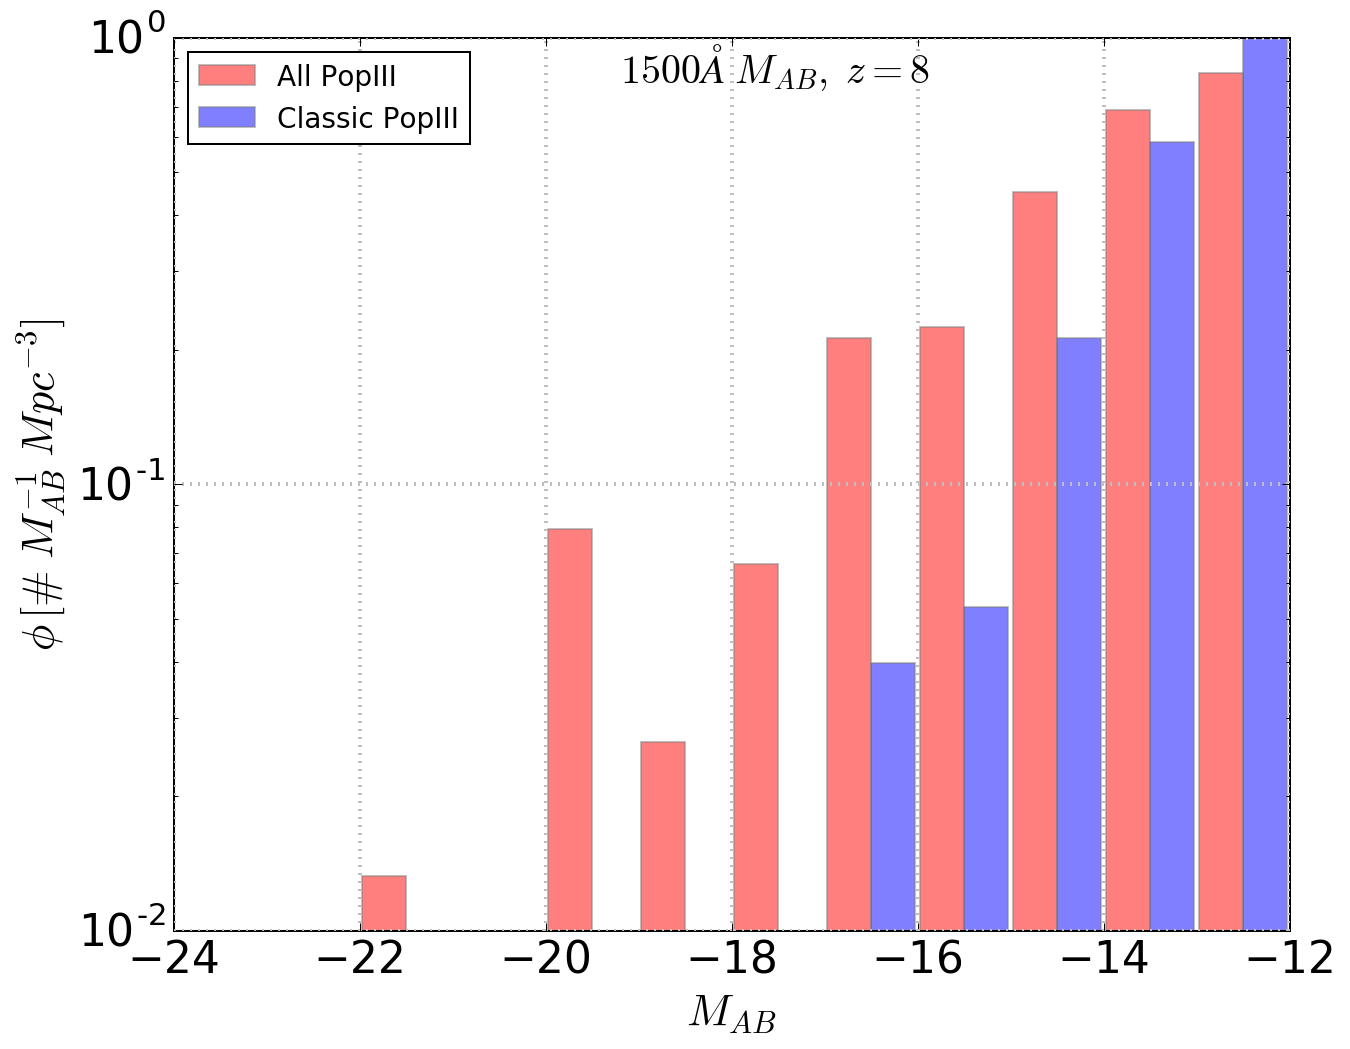

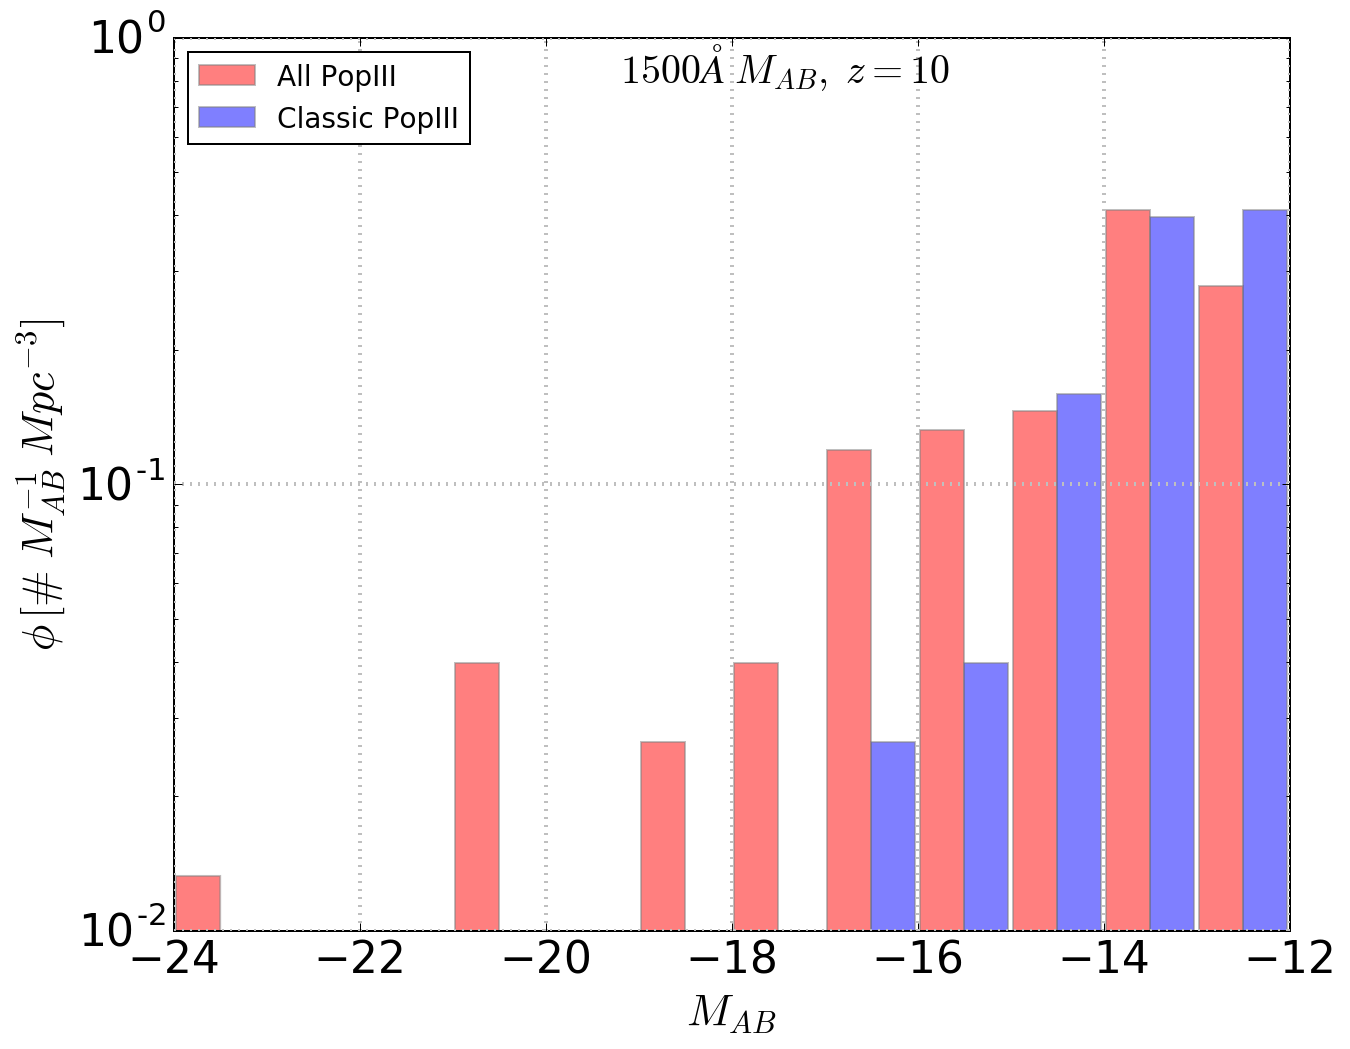

In [69]:
print("Limiting absolute magnitude: {:d}".format(limitM))
simVol = (3.0/0.71)**3

brightM = -24
limitM  = -12
pwrLawMinM = -12

rgForSFunc = np.arange(brightM,limitM, 0.1)

for z in [8,10]:
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Convert observed magnitude to Absolute ...
    convertToM = -2.5*np.log10((cosmo.comoving_distance(z)/(10 * u.pc))**2 * (1+z))
    
    print("Convert to Abs Mag - factor = {:.2f}".format(convertToM))
    
    absMag, nmAbsMag = compMags(z)
    
    if z > 13:
        brightM = -23
        limitM  = -11

    magBins    = np.arange(brightM,limitM+1)
    rgForSFunc = np.arange(brightM,limitM, 0.1)

    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    n, bins, patches = ax.hist([absMag,nmAbsMag],bins=magBins,log=True, color='rb',
                               edgecolor=(0.5,0.5,0.5,0.5), alpha=0.5,rwidth = 0.95,
                               weights=[[1.0/simVol for i in absMag],
                                        [1.0/simVol for i in nmAbsMag]]) 

    ax.legend(['All PopIII','Classic PopIII'], 
              loc='upper left', fontsize=14 )
    # Find bin-centers
    binDelta = (bins[0]-bins[1])/2.0
    print(binDelta)
    binCenters = bins[1::]+binDelta
        
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_xlim([brightM,limitM])
    ax.set_ylim([1e-2,1])

    ax.annotate(r'$1500\AA\;M_{AB},$'+'$\; z={}$'.format(z),xycoords='axes fraction',  xy=(.5,.5), 
                    textcoords='axes fraction', xytext=(.4,.95),size=20)
    ax.set_xlabel('$M_{AB}$')
    ax.set_ylabel(r'$\phi\, [\#\; M_{AB}^{-1}\; Mpc^{-3}]$')
    ax.grid(color='0.75', linestyle=':', linewidth=2)

#     plt.gca().invert_xaxis()
    plt.savefig("haloZVsUVMag_{:.1f}_clean_betterlabel.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    gc.collect()
gc.collect()